In [2]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 

In [3]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [4]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [5]:

data_name="dd_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [6]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [7]:


configs.specifier = specifier
configs.data_name = data_name



In [8]:

configs.specifier



'dd_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [9]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [10]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [11]:

df_data_to_use.head()



,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0


In [12]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [13]:

x_org.head()



,Sex_2,Sex_1,Grade_4,Grade_6,Grade_3,Grade_1,Age,Grade_5,Grade_2,IQ
0,0,1,1,0,0,0,10,0,0,23
1,0,1,1,0,0,0,10,0,0,34
2,1,0,1,0,0,0,10,0,0,34
3,0,1,0,0,0,0,9,0,1,28
4,1,0,0,0,0,0,8,0,1,32


In [14]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [15]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,139.0
2,1,110.0
3,1,71.0
4,1,60.0


In [23]:


estimator_name = "mlp_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [24]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (307, 10)


In [25]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [26]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.   , 1.   , 1.   , ..., 0.   , 0.   , 0.381],
                                 [0.   , 1.   , 1.   , ..., 0.   , 0.   , 0.905],
                                 [1.   , 0.   , 1.   , ..., 0.   , 0.   , 0.905],
                                 ...,
                                 [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.905],
                                 [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.762],
                                 [1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.81 ]]),
                          'x_test': array([[1.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.625, 0.   , 0.   ,
                                  0.857],
                                 [0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.375, 0.   , 0.   ,
                                  0.857],
                                 [0.   , 1.   , 1.   , 0.   , 0.   , 0.   , 0.625, 0.   , 0.   ,

## Load the tuned parameters

In [27]:

specifier = "dd_fix_demo" + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)


configs.specifier = specifier
configs.data_name = data_name




In [28]:
specifier

'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [29]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [30]:
# OrderedDict([('activation', 'identity'),
#              ('hidden_layer_sizes', 173),
#              ('max_iter', 31270),
#              ('solver', 'lbfgs')])



In [ ]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [32]:
tuned_params

OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [33]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1,
    tol=0,
    n_iter_no_change=tuned_params["max_iter"],
    
)

mdl


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              n_iter_no_change=49150, solver='lbfgs', tol=0, verbose=1)

In [34]:
x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [36]:

x_train.shape, y_train.shape


((276, 10), (276,))

In [37]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




In [38]:
# from joblib import dump, load


# mdl = load(configs.models_path.joinpath(configs.specifier+".joblib"))
# mdl


In [39]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )




# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
#     y_prob_ = results[i]["y_pred_prob"]
    
#     cm = sklearn.metrics.confusion_matrix(
#     y_true=y_test_, 
#     y_pred=y_pred_
#     )
    
#     disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=class_names
#                              )
#     disp.plot()
#     plt.show()
    
    
#     print(
#         "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
#         "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
#                                                   multi_class="ovr",
#                                                   average="weighted")
#     )





In [40]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )



In [41]:
y_train.shape, x_test.shape

((276,), (31, 10))

In [42]:


mdl.fit(x_train, y_train)




 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2215     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22899D+00    |proj g|=  4.36566D-01

At iterate    1    f=  9.63281D-01    |proj g|=  2.19267D-01

At iterate    2    f=  7.72487D-01    |proj g|=  7.50571D-02

At iterate    3    f=  7.54322D-01    |proj g|=  4.20966D-02

At iterate    4    f=  7.48641D-01    |proj g|=  1.20582D-02

At iterate    5    f=  7.43401D-01    |proj g|=  7.77657D-03

At iterate    6    f=  7.33844D-01    |proj g|=  2.17016D-02

At iterate    7    f=  7.25685D-01    |proj g|=  1.73682D-02

At iterate    8    f=  7.20188D-01    |proj g|=  2.15291D-02

At iterate    9    f=  7.15495D-01    |proj g|=  3.55918D-03

At iterate   10    f=  7.13630D-01    |proj g|=  3.40657D-03

At iterate   11    f=  7.10587D-01    |proj g|=  4.66024D-03

At iterate   12    f=  7.08802D-01    |proj g|=  2.77995D-03

At iterate   13    f=  7.0


At iterate  154    f=  6.13193D-01    |proj g|=  1.88052D-02

At iterate  155    f=  6.12119D-01    |proj g|=  1.06674D-02

At iterate  156    f=  6.11065D-01    |proj g|=  5.61487D-03

At iterate  157    f=  6.09773D-01    |proj g|=  1.16035D-02

At iterate  158    f=  6.08729D-01    |proj g|=  7.42725D-03

At iterate  159    f=  6.07687D-01    |proj g|=  1.07586D-02

At iterate  160    f=  6.06856D-01    |proj g|=  5.98895D-03

At iterate  161    f=  6.06639D-01    |proj g|=  7.07220D-03

At iterate  162    f=  6.06497D-01    |proj g|=  6.44416D-03

At iterate  163    f=  6.05977D-01    |proj g|=  6.84315D-03

At iterate  164    f=  6.05271D-01    |proj g|=  6.03248D-03

At iterate  165    f=  6.04765D-01    |proj g|=  1.50948D-02

At iterate  166    f=  6.04007D-01    |proj g|=  7.26914D-03

At iterate  167    f=  6.02977D-01    |proj g|=  8.10016D-03

At iterate  168    f=  6.02033D-01    |proj g|=  8.86374D-03

At iterate  169    f=  6.01292D-01    |proj g|=  1.19924D-02

At iter


At iterate  334    f=  4.85361D-01    |proj g|=  9.16838D-03

At iterate  335    f=  4.85041D-01    |proj g|=  2.34571D-02

At iterate  336    f=  4.84388D-01    |proj g|=  1.56582D-02

At iterate  337    f=  4.84039D-01    |proj g|=  8.72290D-03

At iterate  338    f=  4.83533D-01    |proj g|=  1.02522D-02

At iterate  339    f=  4.82717D-01    |proj g|=  9.71123D-03

At iterate  340    f=  4.82093D-01    |proj g|=  4.76305D-02

At iterate  341    f=  4.80998D-01    |proj g|=  2.01779D-02

At iterate  342    f=  4.80348D-01    |proj g|=  1.20677D-02

At iterate  343    f=  4.79936D-01    |proj g|=  6.47206D-02

At iterate  344    f=  4.78983D-01    |proj g|=  2.57425D-02

At iterate  345    f=  4.78403D-01    |proj g|=  1.31279D-02

At iterate  346    f=  4.77653D-01    |proj g|=  1.51072D-02

At iterate  347    f=  4.76607D-01    |proj g|=  2.20218D-02

At iterate  348    f=  4.75850D-01    |proj g|=  1.95365D-02

At iterate  349    f=  4.75251D-01    |proj g|=  1.15719D-02

At iter


At iterate  479    f=  4.15749D-01    |proj g|=  1.40940D-02

At iterate  480    f=  4.15650D-01    |proj g|=  7.11907D-03

At iterate  481    f=  4.15499D-01    |proj g|=  1.40191D-02

At iterate  482    f=  4.15236D-01    |proj g|=  1.02949D-02

At iterate  483    f=  4.15072D-01    |proj g|=  3.92542D-02

At iterate  484    f=  4.14768D-01    |proj g|=  1.88825D-02

At iterate  485    f=  4.14458D-01    |proj g|=  8.57690D-03

At iterate  486    f=  4.14161D-01    |proj g|=  1.71976D-02

At iterate  487    f=  4.13769D-01    |proj g|=  1.81774D-02

At iterate  488    f=  4.13649D-01    |proj g|=  2.89041D-02

At iterate  489    f=  4.13358D-01    |proj g|=  9.95952D-03

At iterate  490    f=  4.13184D-01    |proj g|=  8.89335D-03

At iterate  491    f=  4.13001D-01    |proj g|=  1.49678D-02

At iterate  492    f=  4.12925D-01    |proj g|=  6.26079D-02

At iterate  493    f=  4.12604D-01    |proj g|=  2.25078D-02

At iterate  494    f=  4.12469D-01    |proj g|=  7.76893D-03

At iter


At iterate  640    f=  3.85424D-01    |proj g|=  2.00166D-02

At iterate  641    f=  3.85323D-01    |proj g|=  1.51666D-02

At iterate  642    f=  3.85062D-01    |proj g|=  1.05715D-02

At iterate  643    f=  3.84764D-01    |proj g|=  1.20288D-02

At iterate  644    f=  3.84464D-01    |proj g|=  9.34012D-03

At iterate  645    f=  3.84094D-01    |proj g|=  6.95148D-03

At iterate  646    f=  3.83833D-01    |proj g|=  1.30132D-02

At iterate  647    f=  3.83654D-01    |proj g|=  9.27237D-03

At iterate  648    f=  3.83486D-01    |proj g|=  1.11704D-02

At iterate  649    f=  3.83341D-01    |proj g|=  1.89173D-02

At iterate  650    f=  3.83164D-01    |proj g|=  9.82824D-03

At iterate  651    f=  3.82746D-01    |proj g|=  1.17670D-02

At iterate  652    f=  3.82414D-01    |proj g|=  1.88496D-02

At iterate  653    f=  3.82275D-01    |proj g|=  5.78772D-02

At iterate  654    f=  3.81747D-01    |proj g|=  9.28259D-03

At iterate  655    f=  3.81625D-01    |proj g|=  8.61527D-03

At iter


At iterate  812    f=  3.67599D-01    |proj g|=  4.99661D-03

At iterate  813    f=  3.67542D-01    |proj g|=  4.79200D-03

At iterate  814    f=  3.67488D-01    |proj g|=  4.96927D-03

At iterate  815    f=  3.67451D-01    |proj g|=  1.02423D-02

At iterate  816    f=  3.67400D-01    |proj g|=  7.90741D-03

At iterate  817    f=  3.67379D-01    |proj g|=  4.67421D-03

At iterate  818    f=  3.67338D-01    |proj g|=  1.19703D-02

At iterate  819    f=  3.67314D-01    |proj g|=  1.38129D-02

At iterate  820    f=  3.67273D-01    |proj g|=  4.20433D-03

At iterate  821    f=  3.67246D-01    |proj g|=  4.39199D-03

At iterate  822    f=  3.67218D-01    |proj g|=  2.73260D-03

At iterate  823    f=  3.67175D-01    |proj g|=  1.33158D-02

At iterate  824    f=  3.67123D-01    |proj g|=  3.80292D-03

At iterate  825    f=  3.67054D-01    |proj g|=  8.42886D-03

At iterate  826    f=  3.67005D-01    |proj g|=  7.93626D-03

At iterate  827    f=  3.66922D-01    |proj g|=  1.12134D-02

At iter


At iterate  980    f=  3.60708D-01    |proj g|=  5.95319D-03

At iterate  981    f=  3.60689D-01    |proj g|=  4.88556D-03

At iterate  982    f=  3.60670D-01    |proj g|=  2.05427D-02

At iterate  983    f=  3.60628D-01    |proj g|=  1.04942D-02

At iterate  984    f=  3.60600D-01    |proj g|=  4.61508D-03

At iterate  985    f=  3.60575D-01    |proj g|=  4.54561D-03

At iterate  986    f=  3.60547D-01    |proj g|=  4.97013D-03

At iterate  987    f=  3.60491D-01    |proj g|=  8.05234D-03

At iterate  988    f=  3.60477D-01    |proj g|=  7.60952D-03

At iterate  989    f=  3.60421D-01    |proj g|=  7.04286D-03

At iterate  990    f=  3.60396D-01    |proj g|=  2.96954D-03

At iterate  991    f=  3.60359D-01    |proj g|=  3.07364D-03

At iterate  992    f=  3.60299D-01    |proj g|=  1.34068D-02

At iterate  993    f=  3.60243D-01    |proj g|=  3.97518D-03

At iterate  994    f=  3.60179D-01    |proj g|=  4.97085D-03

At iterate  995    f=  3.60165D-01    |proj g|=  3.51727D-02

At iter


At iterate 1151    f=  3.42839D-01    |proj g|=  1.47108D-02

At iterate 1152    f=  3.42649D-01    |proj g|=  9.89922D-03

At iterate 1153    f=  3.42480D-01    |proj g|=  7.89107D-03

At iterate 1154    f=  3.42291D-01    |proj g|=  6.12947D-03

At iterate 1155    f=  3.42133D-01    |proj g|=  5.49335D-03

At iterate 1156    f=  3.42052D-01    |proj g|=  1.51772D-02

At iterate 1157    f=  3.41917D-01    |proj g|=  7.49023D-03

At iterate 1158    f=  3.41774D-01    |proj g|=  1.11797D-02

At iterate 1159    f=  3.41668D-01    |proj g|=  8.64610D-03

At iterate 1160    f=  3.41610D-01    |proj g|=  4.68155D-02

At iterate 1161    f=  3.41459D-01    |proj g|=  1.52518D-02

At iterate 1162    f=  3.41356D-01    |proj g|=  7.53982D-03

At iterate 1163    f=  3.41298D-01    |proj g|=  1.18116D-02

At iterate 1164    f=  3.41168D-01    |proj g|=  1.31982D-02

At iterate 1165    f=  3.41015D-01    |proj g|=  1.20571D-02

At iterate 1166    f=  3.40764D-01    |proj g|=  4.79578D-03

At iter


At iterate 1320    f=  3.28404D-01    |proj g|=  2.20738D-03

At iterate 1321    f=  3.28361D-01    |proj g|=  2.78096D-03

At iterate 1322    f=  3.28299D-01    |proj g|=  3.44297D-03

At iterate 1323    f=  3.28225D-01    |proj g|=  3.19573D-03

At iterate 1324    f=  3.28142D-01    |proj g|=  4.73411D-03

At iterate 1325    f=  3.28077D-01    |proj g|=  3.46003D-03

At iterate 1326    f=  3.28019D-01    |proj g|=  2.13293D-03

At iterate 1327    f=  3.27951D-01    |proj g|=  4.04447D-03

At iterate 1328    f=  3.27909D-01    |proj g|=  3.85459D-03

At iterate 1329    f=  3.27877D-01    |proj g|=  2.77703D-03

At iterate 1330    f=  3.27790D-01    |proj g|=  1.56593D-02

At iterate 1331    f=  3.27765D-01    |proj g|=  5.43821D-03

At iterate 1332    f=  3.27748D-01    |proj g|=  3.48460D-03

At iterate 1333    f=  3.27700D-01    |proj g|=  3.03980D-03

At iterate 1334    f=  3.27658D-01    |proj g|=  6.09242D-03

At iterate 1335    f=  3.27587D-01    |proj g|=  7.94462D-03

At iter


At iterate 1496    f=  3.20405D-01    |proj g|=  2.37284D-03

At iterate 1497    f=  3.20383D-01    |proj g|=  3.93804D-03

At iterate 1498    f=  3.20361D-01    |proj g|=  5.17152D-03

At iterate 1499    f=  3.20335D-01    |proj g|=  3.82198D-03

At iterate 1500    f=  3.20279D-01    |proj g|=  2.65147D-03

At iterate 1501    f=  3.20248D-01    |proj g|=  2.12204D-03

At iterate 1502    f=  3.20217D-01    |proj g|=  5.68851D-03

At iterate 1503    f=  3.20186D-01    |proj g|=  2.27238D-03

At iterate 1504    f=  3.20170D-01    |proj g|=  2.07923D-03

At iterate 1505    f=  3.20154D-01    |proj g|=  3.98514D-03

At iterate 1506    f=  3.20143D-01    |proj g|=  2.23756D-03

At iterate 1507    f=  3.20137D-01    |proj g|=  1.74585D-03

At iterate 1508    f=  3.20115D-01    |proj g|=  2.36217D-03

At iterate 1509    f=  3.20084D-01    |proj g|=  4.26852D-03

At iterate 1510    f=  3.20052D-01    |proj g|=  3.34071D-03

At iterate 1511    f=  3.20025D-01    |proj g|=  4.81519D-03

At iter


At iterate 1644    f=  3.16862D-01    |proj g|=  2.31451D-03

At iterate 1645    f=  3.16842D-01    |proj g|=  3.95285D-03

At iterate 1646    f=  3.16826D-01    |proj g|=  3.04703D-03

At iterate 1647    f=  3.16815D-01    |proj g|=  1.38817D-03

At iterate 1648    f=  3.16801D-01    |proj g|=  1.93406D-03

At iterate 1649    f=  3.16786D-01    |proj g|=  1.66032D-03

At iterate 1650    f=  3.16776D-01    |proj g|=  8.22610D-03

At iterate 1651    f=  3.16758D-01    |proj g|=  1.36840D-03

At iterate 1652    f=  3.16751D-01    |proj g|=  1.98319D-03

At iterate 1653    f=  3.16739D-01    |proj g|=  3.04679D-03

At iterate 1654    f=  3.16725D-01    |proj g|=  8.78857D-03

At iterate 1655    f=  3.16705D-01    |proj g|=  3.02304D-03

At iterate 1656    f=  3.16689D-01    |proj g|=  1.15622D-03

At iterate 1657    f=  3.16675D-01    |proj g|=  2.49909D-03

At iterate 1658    f=  3.16661D-01    |proj g|=  1.83816D-03

At iterate 1659    f=  3.16653D-01    |proj g|=  3.52140D-03

At iter

At iterate 1799    f=  3.14423D-01    |proj g|=  2.57263D-03

At iterate 1800    f=  3.14404D-01    |proj g|=  1.99848D-03

At iterate 1801    f=  3.14385D-01    |proj g|=  1.70763D-03

At iterate 1802    f=  3.14370D-01    |proj g|=  1.07114D-02

At iterate 1803    f=  3.14350D-01    |proj g|=  2.30150D-03

At iterate 1804    f=  3.14342D-01    |proj g|=  1.45620D-03

At iterate 1805    f=  3.14327D-01    |proj g|=  2.34647D-03

At iterate 1806    f=  3.14310D-01    |proj g|=  1.81112D-03

At iterate 1807    f=  3.14298D-01    |proj g|=  3.49901D-03

At iterate 1808    f=  3.14283D-01    |proj g|=  1.19157D-03

At iterate 1809    f=  3.14271D-01    |proj g|=  1.38370D-03

At iterate 1810    f=  3.14258D-01    |proj g|=  4.67347D-03

At iterate 1811    f=  3.14242D-01    |proj g|=  3.35077D-03

At iterate 1812    f=  3.14214D-01    |proj g|=  1.37480D-03

At iterate 1813    f=  3.14197D-01    |proj g|=  2.96316D-03

At iterate 1814    f=  3.14193D-01    |proj g|=  6.78566D-03

At itera


At iterate 2019    f=  3.11928D-01    |proj g|=  2.41858D-03

At iterate 2020    f=  3.11918D-01    |proj g|=  1.12947D-03

At iterate 2021    f=  3.11904D-01    |proj g|=  1.47879D-03

At iterate 2022    f=  3.11893D-01    |proj g|=  3.61160D-03

At iterate 2023    f=  3.11889D-01    |proj g|=  7.76718D-03

At iterate 2024    f=  3.11880D-01    |proj g|=  1.07829D-03

At iterate 2025    f=  3.11878D-01    |proj g|=  8.64440D-04

At iterate 2026    f=  3.11873D-01    |proj g|=  1.43706D-03

At iterate 2027    f=  3.11865D-01    |proj g|=  1.80108D-03

At iterate 2028    f=  3.11860D-01    |proj g|=  2.58439D-03

At iterate 2029    f=  3.11854D-01    |proj g|=  1.59035D-03

At iterate 2030    f=  3.11846D-01    |proj g|=  1.94387D-03

At iterate 2031    f=  3.11839D-01    |proj g|=  3.64778D-03

At iterate 2032    f=  3.11829D-01    |proj g|=  1.25330D-03

At iterate 2033    f=  3.11816D-01    |proj g|=  1.64322D-03

At iterate 2034    f=  3.11806D-01    |proj g|=  1.47367D-03

At iter


At iterate 2208    f=  3.09044D-01    |proj g|=  1.01382D-02

At iterate 2209    f=  3.09033D-01    |proj g|=  3.14470D-03

At iterate 2210    f=  3.09024D-01    |proj g|=  3.07282D-03

At iterate 2211    f=  3.09011D-01    |proj g|=  6.00276D-03

At iterate 2212    f=  3.08988D-01    |proj g|=  6.63918D-03

At iterate 2213    f=  3.08953D-01    |proj g|=  7.35322D-03

At iterate 2214    f=  3.08938D-01    |proj g|=  1.13791D-02

At iterate 2215    f=  3.08921D-01    |proj g|=  4.63643D-03

At iterate 2216    f=  3.08910D-01    |proj g|=  3.16450D-03

At iterate 2217    f=  3.08904D-01    |proj g|=  3.95623D-03

At iterate 2218    f=  3.08890D-01    |proj g|=  4.41717D-03

At iterate 2219    f=  3.08886D-01    |proj g|=  5.22923D-03

At iterate 2220    f=  3.08876D-01    |proj g|=  2.29816D-03

At iterate 2221    f=  3.08870D-01    |proj g|=  1.47246D-03

At iterate 2222    f=  3.08865D-01    |proj g|=  7.28358D-03

At iterate 2223    f=  3.08860D-01    |proj g|=  4.35781D-03

At iter


At iterate 2376    f=  3.05843D-01    |proj g|=  1.41729D-02

At iterate 2377    f=  3.05826D-01    |proj g|=  9.22695D-03

At iterate 2378    f=  3.05795D-01    |proj g|=  2.46741D-03

At iterate 2379    f=  3.05779D-01    |proj g|=  2.85631D-03

At iterate 2380    f=  3.05750D-01    |proj g|=  3.40008D-03

At iterate 2381    f=  3.05703D-01    |proj g|=  4.32521D-03

At iterate 2382    f=  3.05689D-01    |proj g|=  3.58225D-03

At iterate 2383    f=  3.05666D-01    |proj g|=  1.52122D-03

At iterate 2384    f=  3.05652D-01    |proj g|=  2.72873D-03

At iterate 2385    f=  3.05646D-01    |proj g|=  1.07098D-02

At iterate 2386    f=  3.05633D-01    |proj g|=  5.04094D-03

At iterate 2387    f=  3.05620D-01    |proj g|=  2.44533D-03

At iterate 2388    f=  3.05613D-01    |proj g|=  2.81025D-03

At iterate 2389    f=  3.05596D-01    |proj g|=  2.49076D-03

At iterate 2390    f=  3.05584D-01    |proj g|=  9.84675D-03

At iterate 2391    f=  3.05567D-01    |proj g|=  3.51388D-03

At iter


At iterate 2562    f=  2.99677D-01    |proj g|=  5.10087D-03

At iterate 2563    f=  2.99634D-01    |proj g|=  5.25991D-03

At iterate 2564    f=  2.99601D-01    |proj g|=  5.77000D-03

At iterate 2565    f=  2.99566D-01    |proj g|=  3.88849D-03

At iterate 2566    f=  2.99521D-01    |proj g|=  2.53006D-03

At iterate 2567    f=  2.99499D-01    |proj g|=  5.58117D-03

At iterate 2568    f=  2.99472D-01    |proj g|=  1.51680D-02

At iterate 2569    f=  2.99437D-01    |proj g|=  3.74120D-03

At iterate 2570    f=  2.99423D-01    |proj g|=  3.67776D-03

At iterate 2571    f=  2.99375D-01    |proj g|=  4.97547D-03

At iterate 2572    f=  2.99309D-01    |proj g|=  4.25042D-03

At iterate 2573    f=  2.99291D-01    |proj g|=  9.03745D-03

At iterate 2574    f=  2.99247D-01    |proj g|=  4.39105D-03

At iterate 2575    f=  2.99213D-01    |proj g|=  2.76380D-03

At iterate 2576    f=  2.99176D-01    |proj g|=  2.69349D-03

At iterate 2577    f=  2.99153D-01    |proj g|=  7.81790D-03

At iter


At iterate 2747    f=  2.93852D-01    |proj g|=  4.82469D-03

At iterate 2748    f=  2.93807D-01    |proj g|=  9.60737D-03

At iterate 2749    f=  2.93774D-01    |proj g|=  1.80682D-02

At iterate 2750    f=  2.93754D-01    |proj g|=  1.32893D-02

At iterate 2751    f=  2.93712D-01    |proj g|=  3.95490D-03

At iterate 2752    f=  2.93685D-01    |proj g|=  6.25236D-03

At iterate 2753    f=  2.93648D-01    |proj g|=  6.90779D-03

At iterate 2754    f=  2.93618D-01    |proj g|=  2.30912D-02

At iterate 2755    f=  2.93550D-01    |proj g|=  1.15853D-02

At iterate 2756    f=  2.93518D-01    |proj g|=  2.47734D-03

At iterate 2757    f=  2.93499D-01    |proj g|=  4.31867D-03

At iterate 2758    f=  2.93475D-01    |proj g|=  5.11273D-03

At iterate 2759    f=  2.93448D-01    |proj g|=  5.50728D-03

At iterate 2760    f=  2.93412D-01    |proj g|=  1.75478D-02

At iterate 2761    f=  2.93390D-01    |proj g|=  8.43233D-03

At iterate 2762    f=  2.93373D-01    |proj g|=  4.25311D-03

At iter


At iterate 2914    f=  2.89613D-01    |proj g|=  7.98301D-03

At iterate 2915    f=  2.89603D-01    |proj g|=  2.93004D-03

At iterate 2916    f=  2.89582D-01    |proj g|=  2.98255D-03

At iterate 2917    f=  2.89556D-01    |proj g|=  2.39379D-03

At iterate 2918    f=  2.89528D-01    |proj g|=  8.73245D-03

At iterate 2919    f=  2.89484D-01    |proj g|=  3.09784D-03

At iterate 2920    f=  2.89458D-01    |proj g|=  3.72725D-03

At iterate 2921    f=  2.89419D-01    |proj g|=  3.94583D-03

At iterate 2922    f=  2.89409D-01    |proj g|=  1.19713D-02

At iterate 2923    f=  2.89386D-01    |proj g|=  3.69814D-03

At iterate 2924    f=  2.89370D-01    |proj g|=  3.11457D-03

At iterate 2925    f=  2.89347D-01    |proj g|=  3.62552D-03

At iterate 2926    f=  2.89324D-01    |proj g|=  4.62802D-03

At iterate 2927    f=  2.89316D-01    |proj g|=  4.09005D-03

At iterate 2928    f=  2.89296D-01    |proj g|=  2.42525D-03

At iterate 2929    f=  2.89286D-01    |proj g|=  1.78221D-03

At iter


At iterate 3079    f=  2.85167D-01    |proj g|=  8.61132D-03

At iterate 3080    f=  2.85088D-01    |proj g|=  5.12850D-03

At iterate 3081    f=  2.85038D-01    |proj g|=  5.86316D-03

At iterate 3082    f=  2.84947D-01    |proj g|=  1.14943D-02

At iterate 3083    f=  2.84910D-01    |proj g|=  9.48385D-03

At iterate 3084    f=  2.84864D-01    |proj g|=  6.26922D-03

At iterate 3085    f=  2.84824D-01    |proj g|=  4.40462D-03

At iterate 3086    f=  2.84749D-01    |proj g|=  1.00971D-02

At iterate 3087    f=  2.84679D-01    |proj g|=  6.55733D-03

At iterate 3088    f=  2.84643D-01    |proj g|=  3.66094D-03

At iterate 3089    f=  2.84586D-01    |proj g|=  1.45932D-02

At iterate 3090    f=  2.84554D-01    |proj g|=  1.15773D-02

At iterate 3091    f=  2.84527D-01    |proj g|=  8.60135D-03

At iterate 3092    f=  2.84446D-01    |proj g|=  3.73436D-03

At iterate 3093    f=  2.84388D-01    |proj g|=  6.45788D-03

At iterate 3094    f=  2.84341D-01    |proj g|=  1.48028D-02

At iter


At iterate 3254    f=  2.75765D-01    |proj g|=  1.99644D-02

At iterate 3255    f=  2.75697D-01    |proj g|=  1.40668D-02

At iterate 3256    f=  2.75557D-01    |proj g|=  6.34757D-03

At iterate 3257    f=  2.75400D-01    |proj g|=  6.04063D-03

At iterate 3258    f=  2.75308D-01    |proj g|=  1.06517D-02

At iterate 3259    f=  2.75218D-01    |proj g|=  1.36221D-02

At iterate 3260    f=  2.75134D-01    |proj g|=  6.61198D-03

At iterate 3261    f=  2.75000D-01    |proj g|=  1.40667D-02

At iterate 3262    f=  2.74961D-01    |proj g|=  1.56685D-02

At iterate 3263    f=  2.74911D-01    |proj g|=  4.22276D-03

At iterate 3264    f=  2.74876D-01    |proj g|=  4.34499D-03

At iterate 3265    f=  2.74822D-01    |proj g|=  5.84788D-03

At iterate 3266    f=  2.74783D-01    |proj g|=  3.43875D-02

At iterate 3267    f=  2.74703D-01    |proj g|=  8.26530D-03

At iterate 3268    f=  2.74671D-01    |proj g|=  4.45058D-03

At iterate 3269    f=  2.74624D-01    |proj g|=  4.67540D-03

At iter


At iterate 3421    f=  2.71636D-01    |proj g|=  1.65490D-03

At iterate 3422    f=  2.71633D-01    |proj g|=  7.89907D-03

At iterate 3423    f=  2.71627D-01    |proj g|=  1.92906D-03

At iterate 3424    f=  2.71622D-01    |proj g|=  2.63695D-03

At iterate 3425    f=  2.71615D-01    |proj g|=  4.03628D-03

At iterate 3426    f=  2.71605D-01    |proj g|=  4.95807D-03

At iterate 3427    f=  2.71598D-01    |proj g|=  3.92210D-03

At iterate 3428    f=  2.71588D-01    |proj g|=  1.45208D-03

At iterate 3429    f=  2.71582D-01    |proj g|=  1.24046D-03

At iterate 3430    f=  2.71574D-01    |proj g|=  1.92870D-03

At iterate 3431    f=  2.71571D-01    |proj g|=  4.94489D-03

At iterate 3432    f=  2.71566D-01    |proj g|=  2.01514D-03

At iterate 3433    f=  2.71561D-01    |proj g|=  1.38507D-03

At iterate 3434    f=  2.71558D-01    |proj g|=  1.04838D-03

At iterate 3435    f=  2.71557D-01    |proj g|=  3.32901D-03

At iterate 3436    f=  2.71555D-01    |proj g|=  1.98165D-03

At iter


At iterate 3585    f=  2.71004D-01    |proj g|=  1.39240D-03

At iterate 3586    f=  2.70999D-01    |proj g|=  1.72937D-03

At iterate 3587    f=  2.70993D-01    |proj g|=  1.81853D-03

At iterate 3588    f=  2.70988D-01    |proj g|=  1.49809D-03

At iterate 3589    f=  2.70982D-01    |proj g|=  1.26182D-03

At iterate 3590    f=  2.70979D-01    |proj g|=  3.46451D-03

At iterate 3591    f=  2.70974D-01    |proj g|=  1.00237D-03

At iterate 3592    f=  2.70972D-01    |proj g|=  1.32593D-03

At iterate 3593    f=  2.70968D-01    |proj g|=  1.49456D-03

At iterate 3594    f=  2.70967D-01    |proj g|=  9.99529D-03

At iterate 3595    f=  2.70962D-01    |proj g|=  1.34122D-03

At iterate 3596    f=  2.70961D-01    |proj g|=  1.92721D-03

At iterate 3597    f=  2.70959D-01    |proj g|=  2.76692D-03

At iterate 3598    f=  2.70955D-01    |proj g|=  1.35498D-03

At iterate 3599    f=  2.70954D-01    |proj g|=  3.93428D-03

At iterate 3600    f=  2.70950D-01    |proj g|=  1.23582D-03

At iter


At iterate 3742    f=  2.70526D-01    |proj g|=  1.23444D-03

At iterate 3743    f=  2.70524D-01    |proj g|=  1.20919D-03

At iterate 3744    f=  2.70522D-01    |proj g|=  1.69719D-03

At iterate 3745    f=  2.70520D-01    |proj g|=  1.32502D-03

At iterate 3746    f=  2.70519D-01    |proj g|=  5.52416D-03

At iterate 3747    f=  2.70517D-01    |proj g|=  1.47093D-03

At iterate 3748    f=  2.70517D-01    |proj g|=  9.80825D-04

At iterate 3749    f=  2.70515D-01    |proj g|=  1.15341D-03

At iterate 3750    f=  2.70513D-01    |proj g|=  1.50164D-03

At iterate 3751    f=  2.70512D-01    |proj g|=  2.04219D-03

At iterate 3752    f=  2.70509D-01    |proj g|=  1.23308D-03

At iterate 3753    f=  2.70508D-01    |proj g|=  1.41300D-03

At iterate 3754    f=  2.70507D-01    |proj g|=  8.70678D-04

At iterate 3755    f=  2.70506D-01    |proj g|=  7.51662D-04

At iterate 3756    f=  2.70504D-01    |proj g|=  8.39168D-04

At iterate 3757    f=  2.70502D-01    |proj g|=  2.89212D-03

At iter


At iterate 3925    f=  2.70305D-01    |proj g|=  1.09844D-03

At iterate 3926    f=  2.70304D-01    |proj g|=  7.82816D-04

At iterate 3927    f=  2.70304D-01    |proj g|=  8.51190D-04

At iterate 3928    f=  2.70304D-01    |proj g|=  1.26214D-03

At iterate 3929    f=  2.70303D-01    |proj g|=  4.60127D-04

At iterate 3930    f=  2.70303D-01    |proj g|=  1.20392D-03

At iterate 3931    f=  2.70302D-01    |proj g|=  1.58081D-03

At iterate 3932    f=  2.70301D-01    |proj g|=  1.49967D-03

At iterate 3933    f=  2.70300D-01    |proj g|=  3.65742D-03

At iterate 3934    f=  2.70299D-01    |proj g|=  1.33115D-03

At iterate 3935    f=  2.70298D-01    |proj g|=  4.25245D-04

At iterate 3936    f=  2.70298D-01    |proj g|=  8.78385D-04

At iterate 3937    f=  2.70297D-01    |proj g|=  7.76371D-04

At iterate 3938    f=  2.70296D-01    |proj g|=  1.25277D-03

At iterate 3939    f=  2.70296D-01    |proj g|=  1.93569D-03

At iterate 3940    f=  2.70295D-01    |proj g|=  9.48229D-04

At iter


At iterate 4107    f=  2.70175D-01    |proj g|=  2.26802D-03

At iterate 4108    f=  2.70174D-01    |proj g|=  2.90073D-03

At iterate 4109    f=  2.70172D-01    |proj g|=  1.06661D-03

At iterate 4110    f=  2.70171D-01    |proj g|=  6.35936D-04

At iterate 4111    f=  2.70169D-01    |proj g|=  6.08399D-04

At iterate 4112    f=  2.70167D-01    |proj g|=  3.07225D-03

At iterate 4113    f=  2.70165D-01    |proj g|=  9.43899D-04

At iterate 4114    f=  2.70164D-01    |proj g|=  1.40403D-03

At iterate 4115    f=  2.70163D-01    |proj g|=  1.92663D-03

At iterate 4116    f=  2.70161D-01    |proj g|=  6.01819D-03

At iterate 4117    f=  2.70159D-01    |proj g|=  1.13959D-03

At iterate 4118    f=  2.70158D-01    |proj g|=  6.92129D-04

At iterate 4119    f=  2.70157D-01    |proj g|=  6.06758D-04

At iterate 4120    f=  2.70157D-01    |proj g|=  6.66521D-04

At iterate 4121    f=  2.70156D-01    |proj g|=  2.33486D-03

At iterate 4122    f=  2.70155D-01    |proj g|=  7.86516D-04

At iter


At iterate 4287    f=  2.69998D-01    |proj g|=  2.83920D-03

At iterate 4288    f=  2.69997D-01    |proj g|=  6.69032D-04

At iterate 4289    f=  2.69997D-01    |proj g|=  9.35963D-04

At iterate 4290    f=  2.69996D-01    |proj g|=  2.33569D-03

At iterate 4291    f=  2.69994D-01    |proj g|=  2.79050D-03

At iterate 4292    f=  2.69992D-01    |proj g|=  2.76333D-03

At iterate 4293    f=  2.69992D-01    |proj g|=  5.25258D-03

At iterate 4294    f=  2.69990D-01    |proj g|=  1.02475D-03

At iterate 4295    f=  2.69989D-01    |proj g|=  9.69827D-04

At iterate 4296    f=  2.69987D-01    |proj g|=  1.20950D-03

At iterate 4297    f=  2.69985D-01    |proj g|=  1.54751D-03

At iterate 4298    f=  2.69983D-01    |proj g|=  1.05715D-03

At iterate 4299    f=  2.69981D-01    |proj g|=  2.58827D-03

At iterate 4300    f=  2.69979D-01    |proj g|=  2.63300D-03

At iterate 4301    f=  2.69978D-01    |proj g|=  9.22166D-04

At iterate 4302    f=  2.69977D-01    |proj g|=  1.24195D-03

At iter


At iterate 4464    f=  2.69806D-01    |proj g|=  5.69572D-04

At iterate 4465    f=  2.69805D-01    |proj g|=  1.03328D-03

At iterate 4466    f=  2.69804D-01    |proj g|=  1.03634D-03

At iterate 4467    f=  2.69804D-01    |proj g|=  2.39217D-03

At iterate 4468    f=  2.69803D-01    |proj g|=  8.25453D-04

At iterate 4469    f=  2.69802D-01    |proj g|=  8.93083D-04

At iterate 4470    f=  2.69802D-01    |proj g|=  1.85656D-03

At iterate 4471    f=  2.69801D-01    |proj g|=  6.69508D-04

At iterate 4472    f=  2.69801D-01    |proj g|=  8.65242D-04

At iterate 4473    f=  2.69799D-01    |proj g|=  9.59576D-04

At iterate 4474    f=  2.69798D-01    |proj g|=  7.48815D-04

At iterate 4475    f=  2.69798D-01    |proj g|=  6.37246D-04

At iterate 4476    f=  2.69796D-01    |proj g|=  1.64955D-03

At iterate 4477    f=  2.69795D-01    |proj g|=  9.66157D-04

At iterate 4478    f=  2.69794D-01    |proj g|=  6.09534D-04

At iterate 4479    f=  2.69792D-01    |proj g|=  1.02614D-03

At iter


At iterate 4645    f=  2.69705D-01    |proj g|=  5.76466D-04

At iterate 4646    f=  2.69705D-01    |proj g|=  2.84219D-04

At iterate 4647    f=  2.69705D-01    |proj g|=  1.82750D-04

At iterate 4648    f=  2.69705D-01    |proj g|=  2.83895D-04

At iterate 4649    f=  2.69705D-01    |proj g|=  3.40721D-04

At iterate 4650    f=  2.69705D-01    |proj g|=  1.17496D-03

At iterate 4651    f=  2.69704D-01    |proj g|=  4.82028D-04

At iterate 4652    f=  2.69704D-01    |proj g|=  5.73351D-04

At iterate 4653    f=  2.69704D-01    |proj g|=  2.31713D-04

At iterate 4654    f=  2.69704D-01    |proj g|=  3.21784D-04

At iterate 4655    f=  2.69704D-01    |proj g|=  4.58544D-04

At iterate 4656    f=  2.69703D-01    |proj g|=  3.93967D-04

At iterate 4657    f=  2.69703D-01    |proj g|=  1.02451D-03

At iterate 4658    f=  2.69703D-01    |proj g|=  5.06022D-04

At iterate 4659    f=  2.69703D-01    |proj g|=  2.19897D-04

At iterate 4660    f=  2.69703D-01    |proj g|=  1.98189D-04

At iter


At iterate 4828    f=  2.69645D-01    |proj g|=  2.02862D-03

At iterate 4829    f=  2.69644D-01    |proj g|=  1.13182D-03

At iterate 4830    f=  2.69643D-01    |proj g|=  2.72322D-03

At iterate 4831    f=  2.69642D-01    |proj g|=  6.67432D-04

At iterate 4832    f=  2.69642D-01    |proj g|=  1.19743D-03

At iterate 4833    f=  2.69641D-01    |proj g|=  1.54231D-03

At iterate 4834    f=  2.69640D-01    |proj g|=  3.23636D-03

At iterate 4835    f=  2.69639D-01    |proj g|=  1.63794D-03

At iterate 4836    f=  2.69638D-01    |proj g|=  5.48683D-04

At iterate 4837    f=  2.69638D-01    |proj g|=  5.66864D-04

At iterate 4838    f=  2.69637D-01    |proj g|=  5.63746D-04

At iterate 4839    f=  2.69636D-01    |proj g|=  1.18216D-03

At iterate 4840    f=  2.69636D-01    |proj g|=  1.20467D-03

At iterate 4841    f=  2.69636D-01    |proj g|=  4.34552D-04

At iterate 4842    f=  2.69635D-01    |proj g|=  5.31618D-04

At iterate 4843    f=  2.69635D-01    |proj g|=  1.40096D-03

At iter


At iterate 5008    f=  2.69580D-01    |proj g|=  3.00531D-04

At iterate 5009    f=  2.69580D-01    |proj g|=  6.63804D-04

At iterate 5010    f=  2.69580D-01    |proj g|=  7.86966D-04

At iterate 5011    f=  2.69579D-01    |proj g|=  7.18816D-04

At iterate 5012    f=  2.69579D-01    |proj g|=  1.07072D-03

At iterate 5013    f=  2.69579D-01    |proj g|=  8.08388D-04

At iterate 5014    f=  2.69579D-01    |proj g|=  5.70760D-04

At iterate 5015    f=  2.69579D-01    |proj g|=  8.05041D-04

At iterate 5016    f=  2.69578D-01    |proj g|=  3.74208D-04

At iterate 5017    f=  2.69578D-01    |proj g|=  5.05684D-04

At iterate 5018    f=  2.69578D-01    |proj g|=  7.45980D-04

At iterate 5019    f=  2.69577D-01    |proj g|=  7.20609D-04

At iterate 5020    f=  2.69577D-01    |proj g|=  5.21732D-04

At iterate 5021    f=  2.69576D-01    |proj g|=  3.53067D-04

At iterate 5022    f=  2.69576D-01    |proj g|=  3.61211D-04

At iterate 5023    f=  2.69576D-01    |proj g|=  7.82543D-04

At iter


At iterate 5150    f=  2.69537D-01    |proj g|=  3.87795D-04

At iterate 5151    f=  2.69537D-01    |proj g|=  4.14617D-04

At iterate 5152    f=  2.69537D-01    |proj g|=  5.53742D-04

At iterate 5153    f=  2.69536D-01    |proj g|=  7.05671D-04

At iterate 5154    f=  2.69536D-01    |proj g|=  1.03126D-03

At iterate 5155    f=  2.69535D-01    |proj g|=  6.00115D-04

At iterate 5156    f=  2.69535D-01    |proj g|=  5.21849D-04

At iterate 5157    f=  2.69535D-01    |proj g|=  1.24281D-03

At iterate 5158    f=  2.69534D-01    |proj g|=  3.90315D-03

At iterate 5159    f=  2.69534D-01    |proj g|=  6.41152D-04

At iterate 5160    f=  2.69534D-01    |proj g|=  4.98554D-04

At iterate 5161    f=  2.69533D-01    |proj g|=  8.11859D-04

At iterate 5162    f=  2.69533D-01    |proj g|=  9.62112D-04

At iterate 5163    f=  2.69532D-01    |proj g|=  1.48537D-03

At iterate 5164    f=  2.69531D-01    |proj g|=  7.66809D-04

At iterate 5165    f=  2.69531D-01    |proj g|=  3.65799D-04

At iter


At iterate 5367    f=  2.69289D-01    |proj g|=  1.85382D-03

At iterate 5368    f=  2.69287D-01    |proj g|=  1.76686D-03

At iterate 5369    f=  2.69283D-01    |proj g|=  2.23688D-03

At iterate 5370    f=  2.69281D-01    |proj g|=  1.58841D-03

At iterate 5371    f=  2.69279D-01    |proj g|=  8.93552D-04

At iterate 5372    f=  2.69278D-01    |proj g|=  1.79398D-03

At iterate 5373    f=  2.69277D-01    |proj g|=  7.28755D-04

At iterate 5374    f=  2.69277D-01    |proj g|=  4.54026D-04

At iterate 5375    f=  2.69276D-01    |proj g|=  6.71991D-04

At iterate 5376    f=  2.69276D-01    |proj g|=  2.33173D-03

At iterate 5377    f=  2.69275D-01    |proj g|=  7.76453D-04

At iterate 5378    f=  2.69275D-01    |proj g|=  6.32735D-04

At iterate 5379    f=  2.69274D-01    |proj g|=  3.14065D-03

At iterate 5380    f=  2.69274D-01    |proj g|=  1.29241D-03

At iterate 5381    f=  2.69273D-01    |proj g|=  7.39199D-04

At iterate 5382    f=  2.69273D-01    |proj g|=  1.68327D-03

At iter


At iterate 5546    f=  2.69071D-01    |proj g|=  7.30238D-04

At iterate 5547    f=  2.69070D-01    |proj g|=  5.61065D-04

At iterate 5548    f=  2.69070D-01    |proj g|=  1.11982D-03

At iterate 5549    f=  2.69069D-01    |proj g|=  1.47554D-03

At iterate 5550    f=  2.69067D-01    |proj g|=  1.00697D-03

At iterate 5551    f=  2.69066D-01    |proj g|=  5.49234D-03

At iterate 5552    f=  2.69064D-01    |proj g|=  9.51666D-04

At iterate 5553    f=  2.69063D-01    |proj g|=  9.91331D-04

At iterate 5554    f=  2.69062D-01    |proj g|=  1.82427D-03

At iterate 5555    f=  2.69061D-01    |proj g|=  2.28965D-03

At iterate 5556    f=  2.69058D-01    |proj g|=  7.97417D-04

At iterate 5557    f=  2.69058D-01    |proj g|=  2.65266D-03

At iterate 5558    f=  2.69057D-01    |proj g|=  7.88366D-04

At iterate 5559    f=  2.69057D-01    |proj g|=  5.02820D-04

At iterate 5560    f=  2.69056D-01    |proj g|=  8.56410D-04

At iterate 5561    f=  2.69056D-01    |proj g|=  9.45769D-04

At iter


At iterate 5717    f=  2.68913D-01    |proj g|=  5.23788D-04

At iterate 5718    f=  2.68913D-01    |proj g|=  1.56937D-03

At iterate 5719    f=  2.68913D-01    |proj g|=  5.64839D-04

At iterate 5720    f=  2.68912D-01    |proj g|=  4.54139D-04

At iterate 5721    f=  2.68912D-01    |proj g|=  6.92353D-04

At iterate 5722    f=  2.68911D-01    |proj g|=  8.28058D-04

At iterate 5723    f=  2.68911D-01    |proj g|=  1.04129D-03

At iterate 5724    f=  2.68911D-01    |proj g|=  2.86326D-04

At iterate 5725    f=  2.68910D-01    |proj g|=  3.29611D-04

At iterate 5726    f=  2.68910D-01    |proj g|=  1.40784D-03

At iterate 5727    f=  2.68910D-01    |proj g|=  9.79422D-04

At iterate 5728    f=  2.68910D-01    |proj g|=  4.57381D-04

At iterate 5729    f=  2.68909D-01    |proj g|=  6.03593D-04

At iterate 5730    f=  2.68909D-01    |proj g|=  7.53635D-04

At iterate 5731    f=  2.68909D-01    |proj g|=  1.73002D-03

At iterate 5732    f=  2.68908D-01    |proj g|=  7.57761D-04

At iter


At iterate 5895    f=  2.68839D-01    |proj g|=  2.59636D-04

At iterate 5896    f=  2.68839D-01    |proj g|=  4.89551D-04

At iterate 5897    f=  2.68839D-01    |proj g|=  1.20909D-03

At iterate 5898    f=  2.68838D-01    |proj g|=  5.15400D-04

At iterate 5899    f=  2.68838D-01    |proj g|=  3.28011D-04

At iterate 5900    f=  2.68838D-01    |proj g|=  3.23594D-04

At iterate 5901    f=  2.68838D-01    |proj g|=  3.07372D-04

At iterate 5902    f=  2.68838D-01    |proj g|=  5.20546D-04

At iterate 5903    f=  2.68837D-01    |proj g|=  7.18755D-04

At iterate 5904    f=  2.68837D-01    |proj g|=  7.52923D-04

At iterate 5905    f=  2.68837D-01    |proj g|=  1.96197D-04

At iterate 5906    f=  2.68837D-01    |proj g|=  2.29210D-04

At iterate 5907    f=  2.68837D-01    |proj g|=  3.48716D-04

At iterate 5908    f=  2.68837D-01    |proj g|=  4.43589D-04

At iterate 5909    f=  2.68837D-01    |proj g|=  3.44923D-04

At iterate 5910    f=  2.68837D-01    |proj g|=  5.19580D-04

At iter


At iterate 6075    f=  2.68802D-01    |proj g|=  7.72690D-04

At iterate 6076    f=  2.68802D-01    |proj g|=  4.92516D-04

At iterate 6077    f=  2.68802D-01    |proj g|=  3.22212D-04

At iterate 6078    f=  2.68801D-01    |proj g|=  3.89138D-04

At iterate 6079    f=  2.68801D-01    |proj g|=  8.57080D-04

At iterate 6080    f=  2.68800D-01    |proj g|=  3.57753D-04

At iterate 6081    f=  2.68800D-01    |proj g|=  2.98055D-04

At iterate 6082    f=  2.68799D-01    |proj g|=  5.18476D-04

At iterate 6083    f=  2.68799D-01    |proj g|=  6.40695D-04

At iterate 6084    f=  2.68799D-01    |proj g|=  5.83314D-04

At iterate 6085    f=  2.68798D-01    |proj g|=  3.89878D-04

At iterate 6086    f=  2.68798D-01    |proj g|=  6.91521D-04

At iterate 6087    f=  2.68798D-01    |proj g|=  1.66206D-03

At iterate 6088    f=  2.68798D-01    |proj g|=  3.90721D-04

At iterate 6089    f=  2.68798D-01    |proj g|=  6.48515D-04

At iterate 6090    f=  2.68798D-01    |proj g|=  1.14167D-03

At iter


At iterate 6258    f=  2.68732D-01    |proj g|=  2.39637D-04

At iterate 6259    f=  2.68732D-01    |proj g|=  2.28820D-04

At iterate 6260    f=  2.68732D-01    |proj g|=  5.85887D-04

At iterate 6261    f=  2.68732D-01    |proj g|=  5.26856D-04

At iterate 6262    f=  2.68732D-01    |proj g|=  5.73306D-04

At iterate 6263    f=  2.68732D-01    |proj g|=  7.55466D-04

At iterate 6264    f=  2.68731D-01    |proj g|=  6.44491D-04

At iterate 6265    f=  2.68731D-01    |proj g|=  1.38206D-03

At iterate 6266    f=  2.68730D-01    |proj g|=  3.63538D-04

At iterate 6267    f=  2.68730D-01    |proj g|=  2.85182D-04

At iterate 6268    f=  2.68729D-01    |proj g|=  6.12047D-04

At iterate 6269    f=  2.68729D-01    |proj g|=  1.40291D-03

At iterate 6270    f=  2.68729D-01    |proj g|=  4.84171D-04

At iterate 6271    f=  2.68729D-01    |proj g|=  2.53645D-04

At iterate 6272    f=  2.68729D-01    |proj g|=  2.89334D-04

At iterate 6273    f=  2.68728D-01    |proj g|=  3.64621D-04

At iter


At iterate 6435    f=  2.68695D-01    |proj g|=  2.46554D-04

At iterate 6436    f=  2.68695D-01    |proj g|=  3.56647D-04

At iterate 6437    f=  2.68694D-01    |proj g|=  5.06969D-04

At iterate 6438    f=  2.68694D-01    |proj g|=  3.23657D-04

At iterate 6439    f=  2.68694D-01    |proj g|=  2.75275D-04

At iterate 6440    f=  2.68694D-01    |proj g|=  8.89601D-04

At iterate 6441    f=  2.68694D-01    |proj g|=  5.15966D-04

At iterate 6442    f=  2.68694D-01    |proj g|=  1.74234D-04

At iterate 6443    f=  2.68694D-01    |proj g|=  4.20211D-04

At iterate 6444    f=  2.68694D-01    |proj g|=  6.03533D-04

At iterate 6445    f=  2.68694D-01    |proj g|=  9.44714D-04

At iterate 6446    f=  2.68694D-01    |proj g|=  4.98370D-04

At iterate 6447    f=  2.68694D-01    |proj g|=  2.73845D-04

At iterate 6448    f=  2.68694D-01    |proj g|=  3.13484D-04

At iterate 6449    f=  2.68693D-01    |proj g|=  4.74877D-04

At iterate 6450    f=  2.68693D-01    |proj g|=  6.49381D-04

At iter


At iterate 6610    f=  2.68656D-01    |proj g|=  2.17161D-04

At iterate 6611    f=  2.68656D-01    |proj g|=  7.11496D-04

At iterate 6612    f=  2.68656D-01    |proj g|=  9.70938D-04

At iterate 6613    f=  2.68656D-01    |proj g|=  7.63210D-04

At iterate 6614    f=  2.68656D-01    |proj g|=  2.68585D-04

At iterate 6615    f=  2.68656D-01    |proj g|=  2.13600D-04

At iterate 6616    f=  2.68655D-01    |proj g|=  3.30257D-04

At iterate 6617    f=  2.68655D-01    |proj g|=  1.00231D-03

At iterate 6618    f=  2.68655D-01    |proj g|=  6.81581D-04

At iterate 6619    f=  2.68655D-01    |proj g|=  3.06992D-04

At iterate 6620    f=  2.68655D-01    |proj g|=  5.59548D-04

At iterate 6621    f=  2.68655D-01    |proj g|=  8.07785D-04

At iterate 6622    f=  2.68654D-01    |proj g|=  1.35796D-03

At iterate 6623    f=  2.68654D-01    |proj g|=  7.32951D-04

At iterate 6624    f=  2.68654D-01    |proj g|=  3.27367D-04

At iterate 6625    f=  2.68653D-01    |proj g|=  3.36622D-04

At iter


At iterate 6783    f=  2.68631D-01    |proj g|=  3.23666D-04

At iterate 6784    f=  2.68631D-01    |proj g|=  3.89505D-04

At iterate 6785    f=  2.68631D-01    |proj g|=  5.81137D-04

At iterate 6786    f=  2.68631D-01    |proj g|=  9.78618D-04

At iterate 6787    f=  2.68630D-01    |proj g|=  6.97614D-04

At iterate 6788    f=  2.68630D-01    |proj g|=  3.19320D-04

At iterate 6789    f=  2.68630D-01    |proj g|=  4.56625D-04

At iterate 6790    f=  2.68629D-01    |proj g|=  1.12846D-03

At iterate 6791    f=  2.68629D-01    |proj g|=  7.62430D-04

At iterate 6792    f=  2.68629D-01    |proj g|=  5.53795D-04

At iterate 6793    f=  2.68629D-01    |proj g|=  1.50053D-03

At iterate 6794    f=  2.68628D-01    |proj g|=  9.62748D-04

At iterate 6795    f=  2.68628D-01    |proj g|=  9.37889D-04

At iterate 6796    f=  2.68627D-01    |proj g|=  6.67507D-04

At iterate 6797    f=  2.68626D-01    |proj g|=  4.35862D-04

At iterate 6798    f=  2.68626D-01    |proj g|=  2.48480D-03

At iter


At iterate 6955    f=  2.68392D-01    |proj g|=  4.41682D-03

At iterate 6956    f=  2.68388D-01    |proj g|=  2.45075D-03

At iterate 6957    f=  2.68386D-01    |proj g|=  1.44122D-03

At iterate 6958    f=  2.68384D-01    |proj g|=  2.11271D-03

At iterate 6959    f=  2.68381D-01    |proj g|=  2.25525D-03

At iterate 6960    f=  2.68380D-01    |proj g|=  3.18444D-03

At iterate 6961    f=  2.68378D-01    |proj g|=  1.78790D-03

At iterate 6962    f=  2.68376D-01    |proj g|=  1.86751D-03

At iterate 6963    f=  2.68375D-01    |proj g|=  1.50423D-03

At iterate 6964    f=  2.68374D-01    |proj g|=  7.97168D-04

At iterate 6965    f=  2.68373D-01    |proj g|=  2.51952D-03

At iterate 6966    f=  2.68372D-01    |proj g|=  2.74556D-03

At iterate 6967    f=  2.68371D-01    |proj g|=  1.39734D-03

At iterate 6968    f=  2.68371D-01    |proj g|=  5.20113D-04

At iterate 6969    f=  2.68370D-01    |proj g|=  9.15063D-04

At iterate 6970    f=  2.68369D-01    |proj g|=  1.75489D-03

At iter


At iterate 7108    f=  2.68179D-01    |proj g|=  1.00514D-03

At iterate 7109    f=  2.68179D-01    |proj g|=  1.57415D-03

At iterate 7110    f=  2.68177D-01    |proj g|=  4.48984D-04

At iterate 7111    f=  2.68177D-01    |proj g|=  4.22837D-04

At iterate 7112    f=  2.68177D-01    |proj g|=  1.24873D-03

At iterate 7113    f=  2.68176D-01    |proj g|=  8.92927D-04

At iterate 7114    f=  2.68176D-01    |proj g|=  6.29531D-04

At iterate 7115    f=  2.68175D-01    |proj g|=  1.03865D-03

At iterate 7116    f=  2.68175D-01    |proj g|=  1.50492D-03

At iterate 7117    f=  2.68174D-01    |proj g|=  1.11117D-03

At iterate 7118    f=  2.68174D-01    |proj g|=  8.79332D-04

At iterate 7119    f=  2.68173D-01    |proj g|=  4.02882D-04

At iterate 7120    f=  2.68173D-01    |proj g|=  5.99582D-04

At iterate 7121    f=  2.68173D-01    |proj g|=  6.16328D-04

At iterate 7122    f=  2.68172D-01    |proj g|=  4.75264D-04

At iterate 7123    f=  2.68172D-01    |proj g|=  8.73663D-04

At iter


At iterate 7255    f=  2.68111D-01    |proj g|=  1.72616D-03

At iterate 7256    f=  2.68111D-01    |proj g|=  6.93463D-04

At iterate 7257    f=  2.68110D-01    |proj g|=  3.76213D-04

At iterate 7258    f=  2.68110D-01    |proj g|=  5.06799D-04

At iterate 7259    f=  2.68110D-01    |proj g|=  3.77145D-04

At iterate 7260    f=  2.68109D-01    |proj g|=  1.09773D-03

At iterate 7261    f=  2.68109D-01    |proj g|=  3.82267D-04

At iterate 7262    f=  2.68109D-01    |proj g|=  2.21142D-04

At iterate 7263    f=  2.68109D-01    |proj g|=  1.11636D-03

At iterate 7264    f=  2.68108D-01    |proj g|=  3.51652D-04

At iterate 7265    f=  2.68108D-01    |proj g|=  2.05259D-04

At iterate 7266    f=  2.68108D-01    |proj g|=  2.06498D-04

At iterate 7267    f=  2.68108D-01    |proj g|=  5.25209D-04

At iterate 7268    f=  2.68108D-01    |proj g|=  4.78110D-04

At iterate 7269    f=  2.68108D-01    |proj g|=  2.82879D-04

At iterate 7270    f=  2.68107D-01    |proj g|=  4.82330D-04

At iter


At iterate 7430    f=  2.68038D-01    |proj g|=  7.27383D-04

At iterate 7431    f=  2.68037D-01    |proj g|=  3.65539D-04

At iterate 7432    f=  2.68036D-01    |proj g|=  3.38423D-04

At iterate 7433    f=  2.68036D-01    |proj g|=  7.24354D-04

At iterate 7434    f=  2.68036D-01    |proj g|=  1.23580D-03

At iterate 7435    f=  2.68035D-01    |proj g|=  5.47122D-04

At iterate 7436    f=  2.68035D-01    |proj g|=  5.80786D-04

At iterate 7437    f=  2.68034D-01    |proj g|=  8.52101D-04

At iterate 7438    f=  2.68033D-01    |proj g|=  1.24829D-03

At iterate 7439    f=  2.68033D-01    |proj g|=  7.55052D-04

At iterate 7440    f=  2.68032D-01    |proj g|=  4.77554D-04

At iterate 7441    f=  2.68032D-01    |proj g|=  4.35589D-04

At iterate 7442    f=  2.68031D-01    |proj g|=  4.83223D-04

At iterate 7443    f=  2.68031D-01    |proj g|=  2.04882D-03

At iterate 7444    f=  2.68030D-01    |proj g|=  3.27804D-04

At iterate 7445    f=  2.68030D-01    |proj g|=  4.64693D-04

At iter


At iterate 7567    f=  2.68006D-01    |proj g|=  6.14147D-04

At iterate 7568    f=  2.68006D-01    |proj g|=  1.74445D-04

At iterate 7569    f=  2.68005D-01    |proj g|=  1.34064D-04

At iterate 7570    f=  2.68005D-01    |proj g|=  7.97229D-04

At iterate 7571    f=  2.68005D-01    |proj g|=  7.95947D-04

At iterate 7572    f=  2.68005D-01    |proj g|=  2.29014D-04

At iterate 7573    f=  2.68005D-01    |proj g|=  3.28994D-04

At iterate 7574    f=  2.68005D-01    |proj g|=  3.90046D-04

At iterate 7575    f=  2.68005D-01    |proj g|=  8.26413D-04

At iterate 7576    f=  2.68005D-01    |proj g|=  6.17860D-04

At iterate 7577    f=  2.68005D-01    |proj g|=  2.91219D-04

At iterate 7578    f=  2.68005D-01    |proj g|=  2.38090D-04

At iterate 7579    f=  2.68005D-01    |proj g|=  2.95248D-04

At iterate 7580    f=  2.68004D-01    |proj g|=  5.61568D-04

At iterate 7581    f=  2.68004D-01    |proj g|=  1.47133D-04

At iterate 7582    f=  2.68004D-01    |proj g|=  3.01420D-04

At iter


At iterate 7734    f=  2.67949D-01    |proj g|=  6.42797D-04

At iterate 7735    f=  2.67949D-01    |proj g|=  1.36704D-03

At iterate 7736    f=  2.67949D-01    |proj g|=  3.11625D-04

At iterate 7737    f=  2.67948D-01    |proj g|=  5.11289D-04

At iterate 7738    f=  2.67948D-01    |proj g|=  9.02127D-04

At iterate 7739    f=  2.67947D-01    |proj g|=  6.90369D-04

At iterate 7740    f=  2.67946D-01    |proj g|=  2.32873D-03

At iterate 7741    f=  2.67945D-01    |proj g|=  8.50536D-04

At iterate 7742    f=  2.67945D-01    |proj g|=  8.41863D-04

At iterate 7743    f=  2.67945D-01    |proj g|=  1.39353D-03

At iterate 7744    f=  2.67944D-01    |proj g|=  9.70879D-04

At iterate 7745    f=  2.67944D-01    |proj g|=  3.03074D-04

At iterate 7746    f=  2.67944D-01    |proj g|=  7.92965D-04

At iterate 7747    f=  2.67943D-01    |proj g|=  9.25538D-04

At iterate 7748    f=  2.67943D-01    |proj g|=  7.05106D-04

At iterate 7749    f=  2.67943D-01    |proj g|=  5.99039D-04

At iter


At iterate 7892    f=  2.67860D-01    |proj g|=  2.03244D-03

At iterate 7893    f=  2.67860D-01    |proj g|=  1.39566D-03

At iterate 7894    f=  2.67859D-01    |proj g|=  4.18282D-04

At iterate 7895    f=  2.67859D-01    |proj g|=  3.13562D-04

At iterate 7896    f=  2.67858D-01    |proj g|=  6.19724D-04

At iterate 7897    f=  2.67858D-01    |proj g|=  6.66035D-04

At iterate 7898    f=  2.67857D-01    |proj g|=  2.43405D-03

At iterate 7899    f=  2.67857D-01    |proj g|=  1.10685D-03

At iterate 7900    f=  2.67856D-01    |proj g|=  4.69817D-04

At iterate 7901    f=  2.67856D-01    |proj g|=  4.61941D-04

At iterate 7902    f=  2.67856D-01    |proj g|=  5.46800D-04

At iterate 7903    f=  2.67855D-01    |proj g|=  6.23043D-04

At iterate 7904    f=  2.67855D-01    |proj g|=  1.01286D-03

At iterate 7905    f=  2.67854D-01    |proj g|=  1.43639D-03

At iterate 7906    f=  2.67853D-01    |proj g|=  7.62628D-04

At iterate 7907    f=  2.67852D-01    |proj g|=  5.53512D-04

At iter


At iterate 8052    f=  2.67613D-01    |proj g|=  4.51256D-04

At iterate 8053    f=  2.67612D-01    |proj g|=  8.75020D-04

At iterate 8054    f=  2.67611D-01    |proj g|=  1.27519D-03

At iterate 8055    f=  2.67610D-01    |proj g|=  1.53578D-03

At iterate 8056    f=  2.67610D-01    |proj g|=  3.09774D-03

At iterate 8057    f=  2.67609D-01    |proj g|=  1.28820D-03

At iterate 8058    f=  2.67608D-01    |proj g|=  4.21510D-04

At iterate 8059    f=  2.67608D-01    |proj g|=  1.13953D-03

At iterate 8060    f=  2.67607D-01    |proj g|=  1.55927D-03

At iterate 8061    f=  2.67606D-01    |proj g|=  1.25228D-03

At iterate 8062    f=  2.67606D-01    |proj g|=  2.72399D-03

At iterate 8063    f=  2.67603D-01    |proj g|=  8.06260D-04

At iterate 8064    f=  2.67602D-01    |proj g|=  7.25515D-04

At iterate 8065    f=  2.67601D-01    |proj g|=  8.76880D-04

At iterate 8066    f=  2.67599D-01    |proj g|=  1.78820D-03

At iterate 8067    f=  2.67595D-01    |proj g|=  3.25387D-03

At iter


At iterate 8207    f=  2.67410D-01    |proj g|=  1.75868D-03

At iterate 8208    f=  2.67409D-01    |proj g|=  8.23194D-04

At iterate 8209    f=  2.67408D-01    |proj g|=  7.43933D-04

At iterate 8210    f=  2.67406D-01    |proj g|=  1.49677D-03

At iterate 8211    f=  2.67403D-01    |proj g|=  1.26637D-03

At iterate 8212    f=  2.67402D-01    |proj g|=  3.17900D-03

At iterate 8213    f=  2.67400D-01    |proj g|=  8.98300D-04

At iterate 8214    f=  2.67398D-01    |proj g|=  7.53802D-04

At iterate 8215    f=  2.67397D-01    |proj g|=  4.59765D-03

At iterate 8216    f=  2.67396D-01    |proj g|=  2.21183D-03

At iterate 8217    f=  2.67394D-01    |proj g|=  7.34737D-04

At iterate 8218    f=  2.67394D-01    |proj g|=  1.04713D-03

At iterate 8219    f=  2.67393D-01    |proj g|=  1.29152D-03

At iterate 8220    f=  2.67392D-01    |proj g|=  2.33801D-03

At iterate 8221    f=  2.67390D-01    |proj g|=  1.08358D-03

At iterate 8222    f=  2.67389D-01    |proj g|=  8.89174D-04

At iter


At iterate 8358    f=  2.67124D-01    |proj g|=  1.21202D-03

At iterate 8359    f=  2.67121D-01    |proj g|=  1.54046D-03

At iterate 8360    f=  2.67120D-01    |proj g|=  1.73405D-03

At iterate 8361    f=  2.67117D-01    |proj g|=  7.66402D-04

At iterate 8362    f=  2.67115D-01    |proj g|=  9.34651D-04

At iterate 8363    f=  2.67114D-01    |proj g|=  1.26516D-03

At iterate 8364    f=  2.67111D-01    |proj g|=  1.37865D-03

At iterate 8365    f=  2.67110D-01    |proj g|=  3.39211D-03

At iterate 8366    f=  2.67108D-01    |proj g|=  9.02534D-04

At iterate 8367    f=  2.67107D-01    |proj g|=  2.37020D-03

At iterate 8368    f=  2.67106D-01    |proj g|=  2.93918D-03

At iterate 8369    f=  2.67106D-01    |proj g|=  1.40369D-03

At iterate 8370    f=  2.67105D-01    |proj g|=  9.62567D-04

At iterate 8371    f=  2.67104D-01    |proj g|=  2.65292D-03

At iterate 8372    f=  2.67102D-01    |proj g|=  3.31115D-03

At iterate 8373    f=  2.67099D-01    |proj g|=  3.97155D-03

At iter


At iterate 8537    f=  2.66700D-01    |proj g|=  1.69500D-03

At iterate 8538    f=  2.66695D-01    |proj g|=  3.05895D-03

At iterate 8539    f=  2.66689D-01    |proj g|=  2.01307D-03

At iterate 8540    f=  2.66686D-01    |proj g|=  1.72001D-03

At iterate 8541    f=  2.66680D-01    |proj g|=  2.99282D-03

At iterate 8542    f=  2.66677D-01    |proj g|=  1.87717D-03

At iterate 8543    f=  2.66673D-01    |proj g|=  1.12959D-03

At iterate 8544    f=  2.66670D-01    |proj g|=  1.78559D-03

At iterate 8545    f=  2.66667D-01    |proj g|=  1.65923D-03

At iterate 8546    f=  2.66662D-01    |proj g|=  2.59589D-03

At iterate 8547    f=  2.66661D-01    |proj g|=  3.37560D-03

At iterate 8548    f=  2.66659D-01    |proj g|=  3.25658D-03

At iterate 8549    f=  2.66654D-01    |proj g|=  1.23612D-03

At iterate 8550    f=  2.66651D-01    |proj g|=  7.57325D-04

At iterate 8551    f=  2.66649D-01    |proj g|=  2.15504D-03

At iterate 8552    f=  2.66646D-01    |proj g|=  1.16469D-03

At iter


At iterate 8683    f=  2.66519D-01    |proj g|=  1.52521D-03

At iterate 8684    f=  2.66518D-01    |proj g|=  8.97358D-04

At iterate 8685    f=  2.66518D-01    |proj g|=  5.14677D-04

At iterate 8686    f=  2.66517D-01    |proj g|=  4.37961D-04

At iterate 8687    f=  2.66516D-01    |proj g|=  1.10209D-03

At iterate 8688    f=  2.66515D-01    |proj g|=  1.41660D-03

At iterate 8689    f=  2.66514D-01    |proj g|=  6.26922D-04

At iterate 8690    f=  2.66513D-01    |proj g|=  5.83600D-04

At iterate 8691    f=  2.66512D-01    |proj g|=  2.42880D-03

At iterate 8692    f=  2.66511D-01    |proj g|=  9.26719D-04

At iterate 8693    f=  2.66511D-01    |proj g|=  7.68276D-04

At iterate 8694    f=  2.66510D-01    |proj g|=  1.00647D-03

At iterate 8695    f=  2.66509D-01    |proj g|=  1.25386D-03

At iterate 8696    f=  2.66509D-01    |proj g|=  5.64742D-04

At iterate 8697    f=  2.66508D-01    |proj g|=  7.13565D-04

At iterate 8698    f=  2.66507D-01    |proj g|=  9.62705D-04

At iter


At iterate 8819    f=  2.66340D-01    |proj g|=  1.28030D-03

At iterate 8820    f=  2.66340D-01    |proj g|=  8.31111D-04

At iterate 8821    f=  2.66339D-01    |proj g|=  1.16216D-03

At iterate 8822    f=  2.66339D-01    |proj g|=  7.11350D-04

At iterate 8823    f=  2.66339D-01    |proj g|=  4.51479D-04

At iterate 8824    f=  2.66338D-01    |proj g|=  3.31683D-04

At iterate 8825    f=  2.66338D-01    |proj g|=  5.94577D-04

At iterate 8826    f=  2.66337D-01    |proj g|=  1.01770D-03

At iterate 8827    f=  2.66337D-01    |proj g|=  1.61752D-03

At iterate 8828    f=  2.66336D-01    |proj g|=  7.60540D-04

At iterate 8829    f=  2.66335D-01    |proj g|=  4.29912D-04

At iterate 8830    f=  2.66335D-01    |proj g|=  4.29653D-04

At iterate 8831    f=  2.66333D-01    |proj g|=  6.67652D-04

At iterate 8832    f=  2.66333D-01    |proj g|=  3.07794D-03

At iterate 8833    f=  2.66331D-01    |proj g|=  8.50621D-04

At iterate 8834    f=  2.66330D-01    |proj g|=  6.69386D-04

At iter


At iterate 8991    f=  2.66233D-01    |proj g|=  1.59005D-03

At iterate 8992    f=  2.66232D-01    |proj g|=  1.02575D-03

At iterate 8993    f=  2.66232D-01    |proj g|=  3.85039D-04

At iterate 8994    f=  2.66231D-01    |proj g|=  6.70779D-04

At iterate 8995    f=  2.66231D-01    |proj g|=  6.45175D-04

At iterate 8996    f=  2.66230D-01    |proj g|=  1.15511D-03

At iterate 8997    f=  2.66229D-01    |proj g|=  8.47203D-04

At iterate 8998    f=  2.66228D-01    |proj g|=  6.89906D-04

At iterate 8999    f=  2.66228D-01    |proj g|=  5.56994D-04

At iterate 9000    f=  2.66227D-01    |proj g|=  8.76550D-04

At iterate 9001    f=  2.66226D-01    |proj g|=  4.44946D-04

At iterate 9002    f=  2.66226D-01    |proj g|=  1.76816D-03

At iterate 9003    f=  2.66226D-01    |proj g|=  8.23875D-04

At iterate 9004    f=  2.66225D-01    |proj g|=  3.35349D-04

At iterate 9005    f=  2.66225D-01    |proj g|=  7.67433D-04

At iterate 9006    f=  2.66225D-01    |proj g|=  9.14468D-04

At iter


At iterate 9176    f=  2.66156D-01    |proj g|=  7.10369D-04

At iterate 9177    f=  2.66155D-01    |proj g|=  1.01948D-03

At iterate 9178    f=  2.66155D-01    |proj g|=  1.09989D-03

At iterate 9179    f=  2.66154D-01    |proj g|=  6.92654D-04

At iterate 9180    f=  2.66154D-01    |proj g|=  4.51547D-04

At iterate 9181    f=  2.66154D-01    |proj g|=  5.16856D-04

At iterate 9182    f=  2.66153D-01    |proj g|=  8.77169D-04

At iterate 9183    f=  2.66153D-01    |proj g|=  8.13859D-04

At iterate 9184    f=  2.66153D-01    |proj g|=  3.20850D-04

At iterate 9185    f=  2.66152D-01    |proj g|=  2.54658D-04

At iterate 9186    f=  2.66152D-01    |proj g|=  2.71142D-04

At iterate 9187    f=  2.66152D-01    |proj g|=  1.18865D-03

At iterate 9188    f=  2.66152D-01    |proj g|=  3.92414D-04

At iterate 9189    f=  2.66152D-01    |proj g|=  2.27638D-04

At iterate 9190    f=  2.66151D-01    |proj g|=  7.24825D-04

At iterate 9191    f=  2.66151D-01    |proj g|=  4.14855D-04

At iter


At iterate 9359    f=  2.66110D-01    |proj g|=  8.14053D-04

At iterate 9360    f=  2.66110D-01    |proj g|=  2.49212D-03

At iterate 9361    f=  2.66109D-01    |proj g|=  1.32685D-03

At iterate 9362    f=  2.66108D-01    |proj g|=  5.23039D-04

At iterate 9363    f=  2.66108D-01    |proj g|=  6.00820D-04

At iterate 9364    f=  2.66108D-01    |proj g|=  1.72499D-03

At iterate 9365    f=  2.66107D-01    |proj g|=  8.84875D-04

At iterate 9366    f=  2.66106D-01    |proj g|=  1.31146D-03

At iterate 9367    f=  2.66105D-01    |proj g|=  1.60550D-03

At iterate 9368    f=  2.66103D-01    |proj g|=  2.13940D-03

At iterate 9369    f=  2.66102D-01    |proj g|=  9.90868D-04

At iterate 9370    f=  2.66101D-01    |proj g|=  6.82544D-04

At iterate 9371    f=  2.66099D-01    |proj g|=  5.15943D-04

At iterate 9372    f=  2.66099D-01    |proj g|=  2.91557D-03

At iterate 9373    f=  2.66098D-01    |proj g|=  1.23562D-03

At iterate 9374    f=  2.66097D-01    |proj g|=  5.11250D-04

At iter

At iterate 9542    f=  2.65997D-01    |proj g|=  5.52168D-04

At iterate 9543    f=  2.65996D-01    |proj g|=  2.77925D-04

At iterate 9544    f=  2.65996D-01    |proj g|=  5.74061D-04

At iterate 9545    f=  2.65996D-01    |proj g|=  4.50774D-04

At iterate 9546    f=  2.65996D-01    |proj g|=  2.68970D-03

At iterate 9547    f=  2.65995D-01    |proj g|=  3.34599D-04

At iterate 9548    f=  2.65995D-01    |proj g|=  4.84046D-04

At iterate 9549    f=  2.65995D-01    |proj g|=  8.45700D-04

At iterate 9550    f=  2.65995D-01    |proj g|=  8.13831D-04

At iterate 9551    f=  2.65995D-01    |proj g|=  5.49181D-04

At iterate 9552    f=  2.65995D-01    |proj g|=  3.86402D-04

At iterate 9553    f=  2.65994D-01    |proj g|=  1.72281D-03

At iterate 9554    f=  2.65994D-01    |proj g|=  9.73859D-04

At iterate 9555    f=  2.65994D-01    |proj g|=  3.87560D-04

At iterate 9556    f=  2.65994D-01    |proj g|=  5.82764D-04

At iterate 9557    f=  2.65993D-01    |proj g|=  6.83620D-04

At itera


At iterate 9729    f=  2.65827D-01    |proj g|=  9.20180D-04

At iterate 9730    f=  2.65825D-01    |proj g|=  1.18361D-03

At iterate 9731    f=  2.65824D-01    |proj g|=  9.63401D-04

At iterate 9732    f=  2.65824D-01    |proj g|=  8.18882D-04

At iterate 9733    f=  2.65823D-01    |proj g|=  8.90418D-04

At iterate 9734    f=  2.65823D-01    |proj g|=  1.02589D-03

At iterate 9735    f=  2.65821D-01    |proj g|=  1.91462D-03

At iterate 9736    f=  2.65820D-01    |proj g|=  8.56308D-04

At iterate 9737    f=  2.65820D-01    |proj g|=  3.34280D-03

At iterate 9738    f=  2.65819D-01    |proj g|=  1.08652D-03

At iterate 9739    f=  2.65819D-01    |proj g|=  6.40972D-04

At iterate 9740    f=  2.65819D-01    |proj g|=  1.72850D-03

At iterate 9741    f=  2.65818D-01    |proj g|=  2.29369D-03

At iterate 9742    f=  2.65817D-01    |proj g|=  2.30589D-03

At iterate 9743    f=  2.65816D-01    |proj g|=  2.25369D-03

At iterate 9744    f=  2.65816D-01    |proj g|=  8.52338D-04

At iter


At iterate 9894    f=  2.65705D-01    |proj g|=  9.44243D-04

At iterate 9895    f=  2.65704D-01    |proj g|=  2.38109D-03

At iterate 9896    f=  2.65703D-01    |proj g|=  1.37523D-03

At iterate 9897    f=  2.65701D-01    |proj g|=  7.13960D-04

At iterate 9898    f=  2.65700D-01    |proj g|=  2.51950D-03

At iterate 9899    f=  2.65699D-01    |proj g|=  6.49170D-04

At iterate 9900    f=  2.65698D-01    |proj g|=  5.26120D-04

At iterate 9901    f=  2.65697D-01    |proj g|=  4.47371D-04

At iterate 9902    f=  2.65696D-01    |proj g|=  5.00197D-04

At iterate 9903    f=  2.65695D-01    |proj g|=  1.34026D-03

At iterate 9904    f=  2.65694D-01    |proj g|=  1.39828D-03

At iterate 9905    f=  2.65693D-01    |proj g|=  4.81271D-04

At iterate 9906    f=  2.65692D-01    |proj g|=  8.10433D-04

At iterate 9907    f=  2.65692D-01    |proj g|=  5.02779D-04

At iterate 9908    f=  2.65691D-01    |proj g|=  2.28263D-03

At iterate 9909    f=  2.65690D-01    |proj g|=  6.75151D-04

At iter


At iterate10049    f=  2.65639D-01    |proj g|=  7.44706D-04

At iterate10050    f=  2.65639D-01    |proj g|=  2.54141D-04

At iterate10051    f=  2.65639D-01    |proj g|=  3.84322D-04

At iterate10052    f=  2.65639D-01    |proj g|=  6.51691D-04

At iterate10053    f=  2.65638D-01    |proj g|=  8.12047D-04

At iterate10054    f=  2.65638D-01    |proj g|=  6.49712D-04

At iterate10055    f=  2.65638D-01    |proj g|=  3.14348D-04

At iterate10056    f=  2.65637D-01    |proj g|=  7.83794D-04

At iterate10057    f=  2.65637D-01    |proj g|=  9.22257D-04

At iterate10058    f=  2.65636D-01    |proj g|=  1.49640D-03

At iterate10059    f=  2.65636D-01    |proj g|=  1.02630D-03

At iterate10060    f=  2.65636D-01    |proj g|=  2.95874D-04

At iterate10061    f=  2.65635D-01    |proj g|=  4.70243D-04

At iterate10062    f=  2.65635D-01    |proj g|=  9.50174D-04

At iterate10063    f=  2.65635D-01    |proj g|=  1.70679D-03

At iterate10064    f=  2.65634D-01    |proj g|=  4.30598D-04

At iter


At iterate10235    f=  2.65606D-01    |proj g|=  1.01315D-03

At iterate10236    f=  2.65606D-01    |proj g|=  2.64284D-04

At iterate10237    f=  2.65605D-01    |proj g|=  2.47232D-04

At iterate10238    f=  2.65605D-01    |proj g|=  3.61443D-04

At iterate10239    f=  2.65605D-01    |proj g|=  6.26480D-04

At iterate10240    f=  2.65605D-01    |proj g|=  4.77184D-04

At iterate10241    f=  2.65604D-01    |proj g|=  9.46238D-04

At iterate10242    f=  2.65604D-01    |proj g|=  1.63050D-04

At iterate10243    f=  2.65604D-01    |proj g|=  1.29111D-04

At iterate10244    f=  2.65604D-01    |proj g|=  6.96577D-04

At iterate10245    f=  2.65604D-01    |proj g|=  3.91501D-04

At iterate10246    f=  2.65604D-01    |proj g|=  1.50754D-04

At iterate10247    f=  2.65604D-01    |proj g|=  2.25241D-04

At iterate10248    f=  2.65604D-01    |proj g|=  8.75622D-04

At iterate10249    f=  2.65604D-01    |proj g|=  3.69832D-04

At iterate10250    f=  2.65604D-01    |proj g|=  1.21357D-04

At iter


At iterate10420    f=  2.65561D-01    |proj g|=  6.04566D-04

At iterate10421    f=  2.65561D-01    |proj g|=  6.11790D-04

At iterate10422    f=  2.65560D-01    |proj g|=  5.13631D-04

At iterate10423    f=  2.65560D-01    |proj g|=  3.07919D-04

At iterate10424    f=  2.65559D-01    |proj g|=  9.92357D-04

At iterate10425    f=  2.65559D-01    |proj g|=  4.12384D-04

At iterate10426    f=  2.65559D-01    |proj g|=  2.63327D-04

At iterate10427    f=  2.65559D-01    |proj g|=  6.16961D-04

At iterate10428    f=  2.65558D-01    |proj g|=  8.15575D-04

At iterate10429    f=  2.65558D-01    |proj g|=  4.23469D-04

At iterate10430    f=  2.65558D-01    |proj g|=  5.62341D-04

At iterate10431    f=  2.65558D-01    |proj g|=  7.38630D-04

At iterate10432    f=  2.65558D-01    |proj g|=  1.57763D-03

At iterate10433    f=  2.65557D-01    |proj g|=  4.36722D-04

At iterate10434    f=  2.65557D-01    |proj g|=  3.25573D-04

At iterate10435    f=  2.65557D-01    |proj g|=  4.58335D-04

At iter


At iterate10589    f=  2.65506D-01    |proj g|=  4.96191D-04

At iterate10590    f=  2.65505D-01    |proj g|=  5.42755D-04

At iterate10591    f=  2.65505D-01    |proj g|=  6.14778D-04

At iterate10592    f=  2.65505D-01    |proj g|=  1.27568D-03

At iterate10593    f=  2.65504D-01    |proj g|=  6.37217D-04

At iterate10594    f=  2.65504D-01    |proj g|=  5.03779D-04

At iterate10595    f=  2.65503D-01    |proj g|=  7.99073D-04

At iterate10596    f=  2.65503D-01    |proj g|=  3.68085D-04

At iterate10597    f=  2.65502D-01    |proj g|=  4.72349D-04

At iterate10598    f=  2.65501D-01    |proj g|=  4.37060D-04

At iterate10599    f=  2.65500D-01    |proj g|=  5.25434D-04

At iterate10600    f=  2.65499D-01    |proj g|=  5.95457D-04

At iterate10601    f=  2.65498D-01    |proj g|=  1.29225D-03

At iterate10602    f=  2.65498D-01    |proj g|=  4.45222D-04

At iterate10603    f=  2.65497D-01    |proj g|=  3.30880D-04

At iterate10604    f=  2.65497D-01    |proj g|=  1.33733D-03

At iter


At iterate10765    f=  2.65406D-01    |proj g|=  2.73395D-03

At iterate10766    f=  2.65405D-01    |proj g|=  2.20035D-03

At iterate10767    f=  2.65402D-01    |proj g|=  7.84318D-04

At iterate10768    f=  2.65400D-01    |proj g|=  8.00103D-04

At iterate10769    f=  2.65399D-01    |proj g|=  1.63432D-03

At iterate10770    f=  2.65398D-01    |proj g|=  1.62654D-03

At iterate10771    f=  2.65397D-01    |proj g|=  5.89320D-04

At iterate10772    f=  2.65397D-01    |proj g|=  5.93449D-04

At iterate10773    f=  2.65397D-01    |proj g|=  9.80923D-04

At iterate10774    f=  2.65395D-01    |proj g|=  1.21906D-03

At iterate10775    f=  2.65394D-01    |proj g|=  1.19104D-03

At iterate10776    f=  2.65393D-01    |proj g|=  4.29124D-03

At iterate10777    f=  2.65392D-01    |proj g|=  2.24912D-03

At iterate10778    f=  2.65392D-01    |proj g|=  7.59083D-04

At iterate10779    f=  2.65391D-01    |proj g|=  4.44948D-04

At iterate10780    f=  2.65390D-01    |proj g|=  6.83515D-04

At iter


At iterate10941    f=  2.65330D-01    |proj g|=  3.90155D-04

At iterate10942    f=  2.65330D-01    |proj g|=  6.39321D-04

At iterate10943    f=  2.65330D-01    |proj g|=  6.03335D-04

At iterate10944    f=  2.65330D-01    |proj g|=  3.32188D-04

At iterate10945    f=  2.65329D-01    |proj g|=  3.98428D-04

At iterate10946    f=  2.65329D-01    |proj g|=  6.66433D-04

At iterate10947    f=  2.65329D-01    |proj g|=  9.84140D-04

At iterate10948    f=  2.65328D-01    |proj g|=  4.77508D-04

At iterate10949    f=  2.65328D-01    |proj g|=  3.73465D-04

At iterate10950    f=  2.65327D-01    |proj g|=  3.86548D-04

At iterate10951    f=  2.65327D-01    |proj g|=  3.56996D-03

At iterate10952    f=  2.65327D-01    |proj g|=  3.25530D-04

At iterate10953    f=  2.65326D-01    |proj g|=  2.44698D-04

At iterate10954    f=  2.65326D-01    |proj g|=  2.60059D-04

At iterate10955    f=  2.65326D-01    |proj g|=  7.77123D-04

At iterate10956    f=  2.65325D-01    |proj g|=  8.29026D-04

At iter


At iterate11126    f=  2.65278D-01    |proj g|=  9.93682D-04

At iterate11127    f=  2.65278D-01    |proj g|=  4.20332D-04

At iterate11128    f=  2.65278D-01    |proj g|=  2.95820D-04

At iterate11129    f=  2.65278D-01    |proj g|=  4.79034D-04

At iterate11130    f=  2.65277D-01    |proj g|=  3.48131D-04

At iterate11131    f=  2.65277D-01    |proj g|=  8.57377D-04

At iterate11132    f=  2.65277D-01    |proj g|=  3.91902D-04

At iterate11133    f=  2.65277D-01    |proj g|=  3.45718D-04

At iterate11134    f=  2.65277D-01    |proj g|=  3.88749D-04

At iterate11135    f=  2.65277D-01    |proj g|=  3.90584D-04

At iterate11136    f=  2.65276D-01    |proj g|=  6.80520D-04

At iterate11137    f=  2.65276D-01    |proj g|=  5.99746D-04

At iterate11138    f=  2.65276D-01    |proj g|=  1.72683D-03

At iterate11139    f=  2.65276D-01    |proj g|=  8.19271D-04

At iterate11140    f=  2.65275D-01    |proj g|=  2.21331D-04

At iterate11141    f=  2.65275D-01    |proj g|=  3.11770D-04

At iter


At iterate11322    f=  2.65219D-01    |proj g|=  3.12196D-04

At iterate11323    f=  2.65218D-01    |proj g|=  4.00044D-04

At iterate11324    f=  2.65218D-01    |proj g|=  3.40791D-04

At iterate11325    f=  2.65218D-01    |proj g|=  8.52352D-04

At iterate11326    f=  2.65218D-01    |proj g|=  1.10875D-03

At iterate11327    f=  2.65217D-01    |proj g|=  2.34345D-04

At iterate11328    f=  2.65217D-01    |proj g|=  3.54192D-04

At iterate11329    f=  2.65217D-01    |proj g|=  4.81102D-04

At iterate11330    f=  2.65217D-01    |proj g|=  5.84882D-04

At iterate11331    f=  2.65217D-01    |proj g|=  1.87851D-03

At iterate11332    f=  2.65216D-01    |proj g|=  5.92856D-04

At iterate11333    f=  2.65216D-01    |proj g|=  4.67055D-04

At iterate11334    f=  2.65215D-01    |proj g|=  2.93099D-04

At iterate11335    f=  2.65215D-01    |proj g|=  6.05875D-04

At iterate11336    f=  2.65215D-01    |proj g|=  1.08894D-03

At iterate11337    f=  2.65214D-01    |proj g|=  7.49051D-04

At iter


At iterate11510    f=  2.65131D-01    |proj g|=  9.57628D-04

At iterate11511    f=  2.65130D-01    |proj g|=  1.38922D-03

At iterate11512    f=  2.65129D-01    |proj g|=  5.26135D-04

At iterate11513    f=  2.65129D-01    |proj g|=  5.41497D-04

At iterate11514    f=  2.65128D-01    |proj g|=  1.61105D-03

At iterate11515    f=  2.65128D-01    |proj g|=  6.50153D-04

At iterate11516    f=  2.65128D-01    |proj g|=  3.40931D-04

At iterate11517    f=  2.65128D-01    |proj g|=  5.52356D-04

At iterate11518    f=  2.65128D-01    |proj g|=  6.62734D-04

At iterate11519    f=  2.65127D-01    |proj g|=  9.71666D-04

At iterate11520    f=  2.65127D-01    |proj g|=  2.89612D-04

At iterate11521    f=  2.65127D-01    |proj g|=  2.81967D-04

At iterate11522    f=  2.65126D-01    |proj g|=  2.48944D-04

At iterate11523    f=  2.65126D-01    |proj g|=  1.43007D-03

At iterate11524    f=  2.65125D-01    |proj g|=  6.10526D-04

At iterate11525    f=  2.65125D-01    |proj g|=  3.43751D-04

At iter


At iterate11653    f=  2.65066D-01    |proj g|=  7.85882D-04

At iterate11654    f=  2.65066D-01    |proj g|=  7.93498D-04

At iterate11655    f=  2.65065D-01    |proj g|=  4.70347D-04

At iterate11656    f=  2.65064D-01    |proj g|=  5.82525D-04

At iterate11657    f=  2.65064D-01    |proj g|=  9.36081D-04

At iterate11658    f=  2.65064D-01    |proj g|=  8.28122D-04

At iterate11659    f=  2.65063D-01    |proj g|=  3.88670D-04

At iterate11660    f=  2.65063D-01    |proj g|=  4.05860D-04

At iterate11661    f=  2.65062D-01    |proj g|=  6.86758D-04

At iterate11662    f=  2.65062D-01    |proj g|=  2.04234D-03

At iterate11663    f=  2.65061D-01    |proj g|=  8.74737D-04

At iterate11664    f=  2.65060D-01    |proj g|=  6.84074D-04

At iterate11665    f=  2.65060D-01    |proj g|=  9.10499D-04

At iterate11666    f=  2.65058D-01    |proj g|=  8.87761D-04

At iterate11667    f=  2.65057D-01    |proj g|=  1.30837D-03

At iterate11668    f=  2.65056D-01    |proj g|=  5.98273D-04

At iter


At iterate11816    f=  2.64953D-01    |proj g|=  8.91505D-04

At iterate11817    f=  2.64952D-01    |proj g|=  4.34746D-04

At iterate11818    f=  2.64951D-01    |proj g|=  5.93382D-04

At iterate11819    f=  2.64951D-01    |proj g|=  1.03379D-03

At iterate11820    f=  2.64950D-01    |proj g|=  3.97195D-04

At iterate11821    f=  2.64950D-01    |proj g|=  3.69899D-04

At iterate11822    f=  2.64949D-01    |proj g|=  3.47096D-04

At iterate11823    f=  2.64949D-01    |proj g|=  1.24869D-03

At iterate11824    f=  2.64949D-01    |proj g|=  3.66154D-04

At iterate11825    f=  2.64948D-01    |proj g|=  3.95816D-04

At iterate11826    f=  2.64948D-01    |proj g|=  8.36631D-04

At iterate11827    f=  2.64947D-01    |proj g|=  9.22187D-04

At iterate11828    f=  2.64946D-01    |proj g|=  8.33623D-04

At iterate11829    f=  2.64945D-01    |proj g|=  7.70751D-04

At iterate11830    f=  2.64943D-01    |proj g|=  2.47808D-03

At iterate11831    f=  2.64942D-01    |proj g|=  8.35572D-04

At iter


At iterate11976    f=  2.64876D-01    |proj g|=  5.86574D-04

At iterate11977    f=  2.64876D-01    |proj g|=  5.65342D-04

At iterate11978    f=  2.64876D-01    |proj g|=  7.71756D-04

At iterate11979    f=  2.64875D-01    |proj g|=  5.97557D-04

At iterate11980    f=  2.64875D-01    |proj g|=  6.45012D-04

At iterate11981    f=  2.64874D-01    |proj g|=  1.50756D-03

At iterate11982    f=  2.64873D-01    |proj g|=  1.01648D-03

At iterate11983    f=  2.64872D-01    |proj g|=  1.03674D-03

At iterate11984    f=  2.64872D-01    |proj g|=  5.45786D-04

At iterate11985    f=  2.64871D-01    |proj g|=  4.61680D-04

At iterate11986    f=  2.64870D-01    |proj g|=  6.13131D-04

At iterate11987    f=  2.64869D-01    |proj g|=  5.61999D-04

At iterate11988    f=  2.64869D-01    |proj g|=  1.55127D-03

At iterate11989    f=  2.64868D-01    |proj g|=  8.14458D-04

At iterate11990    f=  2.64868D-01    |proj g|=  7.06314D-04

At iterate11991    f=  2.64867D-01    |proj g|=  6.78435D-04

At iter


At iterate12113    f=  2.64824D-01    |proj g|=  4.89161D-04

At iterate12114    f=  2.64824D-01    |proj g|=  4.51715D-04

At iterate12115    f=  2.64824D-01    |proj g|=  5.41933D-04

At iterate12116    f=  2.64823D-01    |proj g|=  4.07652D-04

At iterate12117    f=  2.64823D-01    |proj g|=  7.40051D-04

At iterate12118    f=  2.64823D-01    |proj g|=  2.77616D-04

At iterate12119    f=  2.64823D-01    |proj g|=  8.12234D-04

At iterate12120    f=  2.64822D-01    |proj g|=  3.09324D-04

At iterate12121    f=  2.64822D-01    |proj g|=  3.32031D-04

At iterate12122    f=  2.64822D-01    |proj g|=  3.97988D-04

At iterate12123    f=  2.64821D-01    |proj g|=  8.60517D-04

At iterate12124    f=  2.64821D-01    |proj g|=  2.75032D-04

At iterate12125    f=  2.64821D-01    |proj g|=  2.93163D-04

At iterate12126    f=  2.64821D-01    |proj g|=  9.07902D-04

At iterate12127    f=  2.64821D-01    |proj g|=  5.29727D-04

At iterate12128    f=  2.64820D-01    |proj g|=  3.02215D-04

At iter


At iterate12260    f=  2.64779D-01    |proj g|=  4.11874D-04

At iterate12261    f=  2.64779D-01    |proj g|=  3.83676D-04

At iterate12262    f=  2.64778D-01    |proj g|=  1.21510D-03

At iterate12263    f=  2.64778D-01    |proj g|=  3.42178D-04

At iterate12264    f=  2.64778D-01    |proj g|=  3.00885D-04

At iterate12265    f=  2.64778D-01    |proj g|=  2.77639D-04

At iterate12266    f=  2.64778D-01    |proj g|=  1.05131D-03

At iterate12267    f=  2.64777D-01    |proj g|=  5.49668D-04

At iterate12268    f=  2.64777D-01    |proj g|=  3.97977D-04

At iterate12269    f=  2.64777D-01    |proj g|=  4.23781D-04

At iterate12270    f=  2.64777D-01    |proj g|=  3.71830D-04

At iterate12271    f=  2.64777D-01    |proj g|=  1.13024D-03

At iterate12272    f=  2.64776D-01    |proj g|=  4.74811D-04

At iterate12273    f=  2.64776D-01    |proj g|=  1.41360D-04

At iterate12274    f=  2.64776D-01    |proj g|=  3.46570D-04

At iterate12275    f=  2.64776D-01    |proj g|=  3.11054D-04

At iter


At iterate12403    f=  2.64738D-01    |proj g|=  4.99473D-04

At iterate12404    f=  2.64738D-01    |proj g|=  3.87515D-04

At iterate12405    f=  2.64738D-01    |proj g|=  4.11121D-04

At iterate12406    f=  2.64737D-01    |proj g|=  2.69316D-03

At iterate12407    f=  2.64737D-01    |proj g|=  8.90592D-04

At iterate12408    f=  2.64736D-01    |proj g|=  5.41369D-04

At iterate12409    f=  2.64736D-01    |proj g|=  1.14151D-03

At iterate12410    f=  2.64736D-01    |proj g|=  9.58036D-04

At iterate12411    f=  2.64735D-01    |proj g|=  5.85520D-04

At iterate12412    f=  2.64735D-01    |proj g|=  3.06410D-04

At iterate12413    f=  2.64735D-01    |proj g|=  6.66914D-04

At iterate12414    f=  2.64734D-01    |proj g|=  6.11044D-04

At iterate12415    f=  2.64734D-01    |proj g|=  1.49608D-03

At iterate12416    f=  2.64734D-01    |proj g|=  6.80724D-04

At iterate12417    f=  2.64734D-01    |proj g|=  1.98268D-04

At iterate12418    f=  2.64733D-01    |proj g|=  2.35729D-04

At iter


At iterate12550    f=  2.64708D-01    |proj g|=  1.12110D-03

At iterate12551    f=  2.64708D-01    |proj g|=  4.55827D-04

At iterate12552    f=  2.64708D-01    |proj g|=  2.12006D-04

At iterate12553    f=  2.64707D-01    |proj g|=  3.71169D-04

At iterate12554    f=  2.64707D-01    |proj g|=  3.61781D-04

At iterate12555    f=  2.64707D-01    |proj g|=  4.98456D-04

At iterate12556    f=  2.64707D-01    |proj g|=  6.29616D-04

At iterate12557    f=  2.64707D-01    |proj g|=  4.56735D-04

At iterate12558    f=  2.64707D-01    |proj g|=  8.27427D-04

At iterate12559    f=  2.64706D-01    |proj g|=  2.48835D-04

At iterate12560    f=  2.64706D-01    |proj g|=  1.72036D-04

At iterate12561    f=  2.64706D-01    |proj g|=  2.58131D-04

At iterate12562    f=  2.64706D-01    |proj g|=  4.06802D-04

At iterate12563    f=  2.64706D-01    |proj g|=  5.64947D-04

At iterate12564    f=  2.64706D-01    |proj g|=  3.38404D-04

At iterate12565    f=  2.64705D-01    |proj g|=  2.04062D-04

At iter


At iterate12701    f=  2.64685D-01    |proj g|=  3.20810D-04

At iterate12702    f=  2.64685D-01    |proj g|=  2.00506D-04

At iterate12703    f=  2.64685D-01    |proj g|=  2.63436D-04

At iterate12704    f=  2.64685D-01    |proj g|=  2.69060D-04

At iterate12705    f=  2.64685D-01    |proj g|=  4.94501D-04

At iterate12706    f=  2.64685D-01    |proj g|=  7.03734D-04

At iterate12707    f=  2.64685D-01    |proj g|=  2.24516D-04

At iterate12708    f=  2.64685D-01    |proj g|=  2.09027D-04

At iterate12709    f=  2.64685D-01    |proj g|=  3.34129D-04

At iterate12710    f=  2.64685D-01    |proj g|=  1.60364D-04

At iterate12711    f=  2.64685D-01    |proj g|=  7.67522D-04

At iterate12712    f=  2.64684D-01    |proj g|=  2.80549D-04

At iterate12713    f=  2.64684D-01    |proj g|=  2.04924D-04

At iterate12714    f=  2.64684D-01    |proj g|=  3.34654D-04

At iterate12715    f=  2.64684D-01    |proj g|=  4.25425D-04

At iterate12716    f=  2.64684D-01    |proj g|=  5.91827D-04

At iter


At iterate12855    f=  2.64639D-01    |proj g|=  9.73933D-04

At iterate12856    f=  2.64639D-01    |proj g|=  3.56485D-04

At iterate12857    f=  2.64639D-01    |proj g|=  3.10141D-04

At iterate12858    f=  2.64639D-01    |proj g|=  1.36670D-03

At iterate12859    f=  2.64639D-01    |proj g|=  1.01079D-03

At iterate12860    f=  2.64638D-01    |proj g|=  2.98074D-04

At iterate12861    f=  2.64638D-01    |proj g|=  3.23243D-04

At iterate12862    f=  2.64638D-01    |proj g|=  5.22329D-04

At iterate12863    f=  2.64638D-01    |proj g|=  6.54777D-04

At iterate12864    f=  2.64637D-01    |proj g|=  3.58720D-04

At iterate12865    f=  2.64637D-01    |proj g|=  3.28425D-04

At iterate12866    f=  2.64637D-01    |proj g|=  4.41801D-04

At iterate12867    f=  2.64636D-01    |proj g|=  9.59167D-04

At iterate12868    f=  2.64636D-01    |proj g|=  3.71467D-04

At iterate12869    f=  2.64636D-01    |proj g|=  2.99294D-04

At iterate12870    f=  2.64636D-01    |proj g|=  1.09867D-03

At iter


At iterate13004    f=  2.64586D-01    |proj g|=  3.63077D-04

At iterate13005    f=  2.64585D-01    |proj g|=  8.68969D-04

At iterate13006    f=  2.64585D-01    |proj g|=  2.48025D-03

At iterate13007    f=  2.64584D-01    |proj g|=  5.70205D-04

At iterate13008    f=  2.64584D-01    |proj g|=  6.03898D-04

At iterate13009    f=  2.64583D-01    |proj g|=  8.17864D-04

At iterate13010    f=  2.64583D-01    |proj g|=  8.27728D-04

At iterate13011    f=  2.64582D-01    |proj g|=  8.76677D-04

At iterate13012    f=  2.64582D-01    |proj g|=  5.03382D-04

At iterate13013    f=  2.64581D-01    |proj g|=  3.24595D-04

At iterate13014    f=  2.64581D-01    |proj g|=  2.98118D-04

At iterate13015    f=  2.64581D-01    |proj g|=  8.28648D-04

At iterate13016    f=  2.64581D-01    |proj g|=  2.54294D-04

At iterate13017    f=  2.64580D-01    |proj g|=  2.43103D-04

At iterate13018    f=  2.64580D-01    |proj g|=  1.48590D-03

At iterate13019    f=  2.64580D-01    |proj g|=  8.78082D-04

At iter


At iterate13154    f=  2.64470D-01    |proj g|=  6.07630D-04

At iterate13155    f=  2.64469D-01    |proj g|=  8.74534D-04

At iterate13156    f=  2.64468D-01    |proj g|=  1.46120D-03

At iterate13157    f=  2.64467D-01    |proj g|=  1.11580D-03

At iterate13158    f=  2.64467D-01    |proj g|=  6.71536D-04

At iterate13159    f=  2.64466D-01    |proj g|=  1.03256D-03

At iterate13160    f=  2.64465D-01    |proj g|=  5.66784D-04

At iterate13161    f=  2.64465D-01    |proj g|=  5.15268D-04

At iterate13162    f=  2.64463D-01    |proj g|=  7.96976D-04

At iterate13163    f=  2.64461D-01    |proj g|=  1.33771D-03

At iterate13164    f=  2.64461D-01    |proj g|=  1.54292D-03

At iterate13165    f=  2.64460D-01    |proj g|=  1.01735D-03

At iterate13166    f=  2.64459D-01    |proj g|=  6.54747D-04

At iterate13167    f=  2.64459D-01    |proj g|=  7.14556D-04

At iterate13168    f=  2.64457D-01    |proj g|=  8.52529D-04

At iterate13169    f=  2.64455D-01    |proj g|=  7.83124D-04

At iter


At iterate13313    f=  2.64342D-01    |proj g|=  4.64114D-04

At iterate13314    f=  2.64341D-01    |proj g|=  7.90640D-04

At iterate13315    f=  2.64340D-01    |proj g|=  8.54625D-04

At iterate13316    f=  2.64340D-01    |proj g|=  9.97000D-04

At iterate13317    f=  2.64339D-01    |proj g|=  2.20755D-03

At iterate13318    f=  2.64339D-01    |proj g|=  5.76124D-04

At iterate13319    f=  2.64339D-01    |proj g|=  4.01028D-04

At iterate13320    f=  2.64338D-01    |proj g|=  1.07347D-03

At iterate13321    f=  2.64338D-01    |proj g|=  1.61910D-03

At iterate13322    f=  2.64337D-01    |proj g|=  1.85243D-03

At iterate13323    f=  2.64336D-01    |proj g|=  1.75836D-03

At iterate13324    f=  2.64335D-01    |proj g|=  1.61133D-03

At iterate13325    f=  2.64335D-01    |proj g|=  2.04429D-03

At iterate13326    f=  2.64334D-01    |proj g|=  7.43974D-04

At iterate13327    f=  2.64333D-01    |proj g|=  4.60358D-04

At iterate13328    f=  2.64333D-01    |proj g|=  4.68363D-04

At iter


At iterate13470    f=  2.64277D-01    |proj g|=  1.77274D-04

At iterate13471    f=  2.64276D-01    |proj g|=  2.61624D-04

At iterate13472    f=  2.64276D-01    |proj g|=  5.82234D-04

At iterate13473    f=  2.64276D-01    |proj g|=  5.08778D-04

At iterate13474    f=  2.64276D-01    |proj g|=  2.41326D-04

At iterate13475    f=  2.64276D-01    |proj g|=  7.57005D-04

At iterate13476    f=  2.64276D-01    |proj g|=  2.49331D-04

At iterate13477    f=  2.64276D-01    |proj g|=  3.03353D-04

At iterate13478    f=  2.64276D-01    |proj g|=  2.92377D-04

At iterate13479    f=  2.64275D-01    |proj g|=  3.15262D-04

At iterate13480    f=  2.64275D-01    |proj g|=  9.83085D-04

At iterate13481    f=  2.64274D-01    |proj g|=  5.14029D-04

At iterate13482    f=  2.64274D-01    |proj g|=  6.80434D-04

At iterate13483    f=  2.64274D-01    |proj g|=  4.43096D-04

At iterate13484    f=  2.64273D-01    |proj g|=  7.95955D-04

At iterate13485    f=  2.64273D-01    |proj g|=  1.60694D-03

At iter


At iterate13628    f=  2.64244D-01    |proj g|=  2.37875D-04

At iterate13629    f=  2.64244D-01    |proj g|=  2.16572D-04

At iterate13630    f=  2.64244D-01    |proj g|=  2.93366D-04

At iterate13631    f=  2.64243D-01    |proj g|=  3.54982D-04

At iterate13632    f=  2.64243D-01    |proj g|=  5.28248D-04

At iterate13633    f=  2.64243D-01    |proj g|=  3.93857D-04

At iterate13634    f=  2.64243D-01    |proj g|=  1.92006D-04

At iterate13635    f=  2.64243D-01    |proj g|=  1.87072D-04

At iterate13636    f=  2.64242D-01    |proj g|=  2.13664D-04

At iterate13637    f=  2.64242D-01    |proj g|=  2.85950D-04

At iterate13638    f=  2.64242D-01    |proj g|=  1.02828D-03

At iterate13639    f=  2.64242D-01    |proj g|=  3.20516D-04

At iterate13640    f=  2.64242D-01    |proj g|=  3.73900D-04

At iterate13641    f=  2.64242D-01    |proj g|=  2.43631D-04

At iterate13642    f=  2.64241D-01    |proj g|=  6.66037D-04

At iterate13643    f=  2.64241D-01    |proj g|=  4.82988D-04

At iter


At iterate13793    f=  2.64213D-01    |proj g|=  4.80196D-04

At iterate13794    f=  2.64212D-01    |proj g|=  1.14896D-03

At iterate13795    f=  2.64212D-01    |proj g|=  4.07409D-04

At iterate13796    f=  2.64211D-01    |proj g|=  5.88522D-04

At iterate13797    f=  2.64211D-01    |proj g|=  2.97362D-04

At iterate13798    f=  2.64211D-01    |proj g|=  2.89912D-04

At iterate13799    f=  2.64211D-01    |proj g|=  3.07151D-04

At iterate13800    f=  2.64210D-01    |proj g|=  3.11825D-04

At iterate13801    f=  2.64210D-01    |proj g|=  3.28366D-04

At iterate13802    f=  2.64210D-01    |proj g|=  3.04516D-04

At iterate13803    f=  2.64210D-01    |proj g|=  6.32713D-04

At iterate13804    f=  2.64210D-01    |proj g|=  1.66019D-04

At iterate13805    f=  2.64209D-01    |proj g|=  1.78799D-04

At iterate13806    f=  2.64209D-01    |proj g|=  1.88930D-04

At iterate13807    f=  2.64209D-01    |proj g|=  5.09900D-04

At iterate13808    f=  2.64209D-01    |proj g|=  4.41978D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              n_iter_no_change=49150, solver='lbfgs', tol=0, verbose=1)

In [43]:

print("model fitted")



model fitted


In [44]:
mdl.predict_proba(x_test[5:10:, :])




array([[1.   , 0.   , 0.   ],
       [0.999, 0.   , 0.001],
       [1.   , 0.   , 0.   ],
       [0.666, 0.   , 0.334],
       [0.006, 0.   , 0.994]])

In [45]:
mdl.predict(x_test[5:10:, :])



array([1, 1, 1, 1, 3])

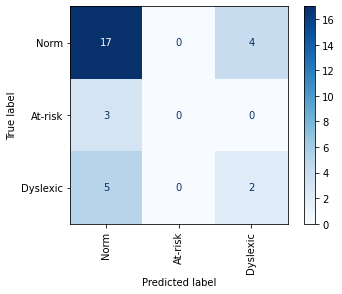

In [46]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




In [47]:

sklearn.metrics.roc_auc_score(y_test, 
                              mdl.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted"
                             )




0.5494047619047618

In [48]:

y_pred = mdl.predict(x_test)


In [49]:


sklearn.metrics.adjusted_rand_score(y_test, y_pred)


-0.02169378389653734

In [50]:

sklearn.metrics.normalized_mutual_info_score(y_test, y_pred)


0.040070795452863885

In [51]:


sklearn.metrics.precision_score(y_test, 
                                y_pred, 
                                average='weighted')



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5359139784946236

In [52]:


sklearn.metrics.recall_score(y_test, y_pred, average='weighted')



0.6129032258064516

In [53]:

sklearn.metrics.f1_score(y_test, y_pred, average='weighted')



0.5701801704606756

In [54]:

sklearn.metrics.accuracy_score(y_test, y_pred)


0.6129032258064516

In [55]:


sklearn.metrics.cohen_kappa_score(y_test, y_pred)



0.055837563451776706

- 




In [ ]:


len(list(x_org.columns)) == x_test.shape[1]




In [ ]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [ ]:


# shap_values = explainer(x_test)




In [ ]:


print("Shap values are determined!")



In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape



- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



### Shap bar plot



In [ ]:

shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




- The bar plot above depicgts the Mean Absolute SHAP (MAS) values for each feature across the entire data. MAS, on average, quantifies, the magnitude of each feature's contribution towards the predicted class labels. The higher the MAS value for a a feature the more influential that feature is.


- The gender SHAP values sums up to 0.35 turning it two one of the most influentioal features. 
- IQ, Age and the third and fourth grades are the other important features in predicing the class labels.
- Althoght the remaining features have less significant SHAP values, still they all plan a role in predicting class labels.

- More info on beeswarm-bar plot 

In [ ]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 

In addition to observe the same pattern on the relative importannce of features, one can observe that:

- There are quite a few sixth grade participants with very high SHAP values despite of its low MAS value in general.

- 



### SHAP Beeswarm Plots


- Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

- The points are distributed horizontally along the x-axis according to their SHAP value. In places where there is a high density of SHAP values, the points are stacked vertically. Examining how the SHAP values are distributed reveals how a variable may influence the model's predictions.

- The colour bar corresponds to the raw values (not to be confused with the SHAP values) of the variables for each instance (i.e. point) on the graph. If the value of a variable for a particular instance is relatively high, it appears as a red dot. Relatively low variable values appear as blue dots. Examining the color distribution horizontally along the x-axis for each variable provides insights into the general relationship between a variable's raw values and its SHAP values.


- These (the columns) are the input variables, ranked from top to bottom by their mean absolute SHAP values for the entire dataset. Note: this ranking is exactly the same as for the bar plot.



In [ ]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




- None-female (male) students have the highest negative SHAP values, implying the significance of this feature on prediction results. 


- Only the two extremes of students' "IQ" have direct impacts models prediction.


- Similar to IQ features, only the two extremes of "Age" feature plays an important role in models prediction.


- Most of the 3rd and 4th grade students, unlike the rest of grades, have high SHAP values which demostrates the importance of these two features.


- Fixation along Y-axis is more important than X-axis. 


- The 6th grade has no low impact on model's prediction result. 





### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

In [ ]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")


- The vertical spread of SHAP values at a fixed raw variable value is due to interaction effects with other variables. For example, here we see that sex_1 equal to unity (female) can have SHAP values that range from $-0.6 to 0.15$ depending on the other data for those particular instances. 


- The shapes of the distributions of points provide insights into the relationship between a variable's values and its SHAP values. We cannot see any specific relation between any individual feature and its importance (its SHAP values).



In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


In [ ]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 


## Individual force plots of 3 randomly selected samples of each class


In [ ]:



normals = np.where(y_test == 1)[0]
at_risks = np.where(y_test == 2)[0]
dyslexics = np.where(y_test == 3)[0]



n_size = 5
np.random.seed(43)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)




In [ ]:
normals_rnd



In [ ]:
at_risks_rnd


In [ ]:

dyslexics_rnd


In [ ]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)
    
    

In [ ]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

In [ ]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)
    
    